<a href="https://colab.research.google.com/github/AinaHerrera/ejerciciosIA/blob/main/Checkpoint_8_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fase 1 — Planeación
1) Planteamiento del problema (1 párrafo)

Queremos evaluar en qué medida el desempeño académico y la preparación profesional universitaria (GPA, SAT, prácticas, proyectos, certificaciones, habilidades blandas y networking) predicen el nivel laboral actual de una persona. Usaremos el dataset Education & Career Success y formularemos el problema como clasificación ordinal sobre Current_Job_Level (Entry < Mid < Senior < Executive), evitando variables de mercado (salario/ofertas) para no sesgar el concepto de desempeño.

2) Objetivo general

Desarrollar y evaluar un modelo de clasificación ordinal que estime el nivel laboral actual (Current_Job_Level) a partir de señales académicas y de preparación profesional.

3) Objetivos específicos

Explorar relaciones entre indicadores académicos/experienciales y el nivel laboral (EDA).

Entrenar modelos ordinales (línea base interpretable + modelo de alto rendimiento).

Evaluar con métricas alineadas a orden (p. ej., Quadratic Weighted Kappa).

Explicar contribuciones de variables (importancias y SHAP) y traducir hallazgos en recomendaciones.

4) Alcance y supuestos

Población: egresados/estudiantes universitarios en áreas de alta demanda (CS, ingeniería, negocios, ciencias, etc.).

Target de desempeño: Current_Job_Level (orden natural Entry<Mid<Senior<Executive).

Variables de mercado (Starting_Salary, Job_Offers) no se usarán como features para evitar leakage conceptual.

Posible naturaleza anónima/sintética del dataset; se asume estructura realista para propósitos de modelado.

5) Variable objetivo y previsión de features

Objetivo (ordinal): Current_Job_Level (mapeo interno: Entry=1, Mid=2, Senior=3, Executive=4).

Predictoras candidatas:

Académicas: High_School_GPA, SAT_Score, University_GPA, Field_of_Study.

Experiencia/skills: Internships_Completed, Projects_Completed, Certifications, Soft_Skills_Score, Networking_Score.

Demográficas (con cautela): Age, Gender (analizar impacto/posibles sesgos).

Variables a excluir del set de features: Job_Offers, Starting_Salary, Career_Satisfaction, Work_Life_Balance, Entrepreneurship (podrían ser objetivos alternos o variables de resultado, no drivers “puros” de desempeño).

6) Preguntas de investigación (RQ)

RQ1: ¿Qué tanto GPA universitario y prácticas/proyectos/certificaciones explican alcanzar niveles Mid/Senior/Executive?

RQ2: ¿Las habilidades blandas y el networking añaden valor predictivo más allá de las notas?

RQ3: ¿Existen interacciones relevantes (p. ej., GPA × prácticas, proyectos × certificaciones)?

RQ4: ¿Cómo varía el desempeño del modelo por Field_of_Study?

7) Hipótesis

H1: Mayor University_GPA y más experiencia práctica (prácticas/proyectos) se asocian con niveles laborales más altos.

H2: Soft_Skills_Score y Networking_Score incrementan la probabilidad de alcanzar niveles superiores, controlando por GPA.

H3: Certifications aporta señal incremental, especialmente en campos técnicos.

8) Diseño de modelado (clasificación ordinal)

Línea base interpretable: Ordinal Logistic (Ordered Logit).

Modelo de desempeño: Gradient Boosting (CatBoost/XGBoost).

Estrategia A: entrenar como multiclase y evaluar con métricas ordinales (penalizando errores lejanos).

Estrategia B: técnica de cumulative link / threshold (si se implementa en framework elegido).

Explicabilidad: Importancias + SHAP (summary/dependence) para interpretar drivers.

9) Métricas de evaluación

Principal: Quadratic Weighted Kappa (QWK) (respeta el orden y penaliza más los errores grandes).

Secundarias: MAE de clase (|y_pred − y_true| en niveles), F1 macro y matriz de confusión ordenada.

Análisis por subgrupos: performance por Field_of_Study y distribución de errores por clase (Entry/Mid/Senior/Executive).

10) Validación, leakage y robustez

Split: Train/Val/Test (70/15/15) con estratificación por nivel; CV (K=5) en entrenamiento para tuning.

Preprocesamiento en pipeline: imputación (mediana/moda), one-hot a Field_of_Study, escalado cuando aplique (modelos lineales).

Prevención de leakage: excluir resultados de carrera/mercado del feature set; ajustar hiperparámetros solo con train/val.

Desbalance de clases: class_weight, técnicas de re-muestreo prudentes y ajuste de umbral si se usa esquema binarizado intermedio.

11) Consideraciones éticas y de sesgo

Auditar impacto de Age/Gender/Field_of_Study; reportar diferencias de error por subgrupos.

Evitar usos deterministas del modelo; comunicar limitaciones y contexto.

Mantener trazabilidad de decisiones (data cards/model cards).

12) Riesgos y mitigaciones

Datos faltantes/ruido: imputación robusta, validación de rangos (ej., GPA 2–4; SAT 900–1600).

Multicolinealidad: regularización (L1/L2) y análisis de correlaciones.

Sobreajuste: early stopping (GBMs), CV, y revisión de complejidad.

Traslape semántico: cuidar que features no sean proxies directos de la etiqueta (p. ej., no usar variables claramente poscontractuales).

13) Entregables

Notebook único (.ipynb) con historia completa: EDA → preparación → modelado ordinal → evaluación → explicabilidad → hallazgos y recomendaciones.

Gráficos clave: distribución por nivel, SHAP summary, errores por clase, QWK vs. baselines.

14) Criterios de éxito

QWK ≥ 0.65 y MAE de clase ≤ 0.40 (error medio menor a “medio nivel”).

Conjunto de drivers coherentes (GPA/prácticas/proyectos/skills) y recomendaciones accionables para estudiantes/centros de carrera.

In [75]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from textwrap import dedent
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix
from catboost import CatBoostClassifier, Pool

from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier, plot_tree
import re






In [2]:
CSV_PATH = "/content/education_career_success.csv"
df = pd.read_csv(CSV_PATH)

print("Dimensiones iniciales:", df.shape)
df.head()


Dimensiones iniciales: (400, 19)


,Student_ID,Age,Gender,High_School_GPA,SAT_Score,University_GPA,Field_of_Study,Internships_Completed,Projects_Completed,Certifications,Soft_Skills_Score,Networking_Score,Job_Offers,Starting_Salary,Career_Satisfaction,Years_to_Promotion,Current_Job_Level,Work_Life_Balance,Entrepreneurship
0,S001,22,Male,3.8,1450,3.6,Computer Science,3,7,2,8,7,3,85000,8,2,Mid,7,No
1,S002,24,Female,3.6,1380,3.4,Business,2,5,3,7,6,2,65000,7,3,Mid,6,No
2,S003,21,Male,3.9,1520,3.8,Engineering,4,9,4,9,8,4,120000,9,1,Senior,6,No
3,S004,23,Female,3.5,1300,3.2,Psychology,1,3,1,6,5,1,48000,6,4,Entry,8,No
4,S005,25,Male,3.7,1420,3.5,Medicine,2,6,2,8,7,3,95000,8,2,Mid,5,No


In [3]:
display(df.sample(5))  # muestra 5 filas aleatorias sin random_state
print("\nInfo():")
df.info()

print("\nPorcentaje de valores faltantes por columna:")
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
display(missing_pct.to_frame("missing_%"))

print("\nValores únicos por columna (primer vistazo):")
uniques = {col: df[col].nunique() for col in df.columns}
pd.Series(uniques).sort_values(ascending=False)



,Student_ID,Age,Gender,High_School_GPA,SAT_Score,University_GPA,Field_of_Study,Internships_Completed,Projects_Completed,Certifications,Soft_Skills_Score,Networking_Score,Job_Offers,Starting_Salary,Career_Satisfaction,Years_to_Promotion,Current_Job_Level,Work_Life_Balance,Entrepreneurship
156,S157,24,Male,3.5,1300,3.3,Law,2,6,2,7,6,2,72000,7,4,Mid,6,No
385,S386,22,Female,3.6,1380,3.4,Business,2,6,2,8,7,2,84000,8,3,Mid,7,No
174,S175,25,Male,3.6,1380,3.4,Law,3,6,3,8,7,3,84000,8,3,Mid,6,No
361,S362,24,Female,3.8,1500,3.7,Engineering,3,8,3,9,8,4,110000,9,2,Mid,6,No
307,S308,23,Female,3.6,1340,3.4,Marketing,2,5,2,7,6,2,76000,7,3,Mid,6,No



Info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Student_ID             400 non-null    object 
 1   Age                    400 non-null    int64  
 2   Gender                 400 non-null    object 
 3   High_School_GPA        400 non-null    float64
 4   SAT_Score              400 non-null    int64  
 5   University_GPA         400 non-null    float64
 6   Field_of_Study         400 non-null    object 
 7   Internships_Completed  400 non-null    int64  
 8   Projects_Completed     400 non-null    int64  
 9   Certifications         400 non-null    int64  
 10  Soft_Skills_Score      400 non-null    int64  
 11  Networking_Score       400 non-null    int64  
 12  Job_Offers             400 non-null    int64  
 13  Starting_Salary        400 non-null    int64  
 14  Career_Satisfaction    400 non-null    int64  
 1

,missing_%
Student_ID,0.0
Age,0.0
Gender,0.0
High_School_GPA,0.0
SAT_Score,0.0
University_GPA,0.0
Field_of_Study,0.0
Internships_Completed,0.0
Projects_Completed,0.0
Certifications,0.0



Valores únicos por columna (primer vistazo):


,0
Student_ID,400
Starting_Salary,63
SAT_Score,35
University_GPA,13
Field_of_Study,11
Projects_Completed,8
High_School_GPA,8
Job_Offers,6
Networking_Score,6
Soft_Skills_Score,6


In [4]:
df.rename(columns={
    "Student_ID": "student_id",
    "Age": "age",
    "Gender": "gender",
    "High_School_GPA": "hs_gpa",
    "SAT_Score": "sat",
    "University_GPA": "uni_gpa",
    "Field_of_Study": "field_of_study",
    "Internships_Completed": "internships",
    "Projects_Completed": "projects",
    "Certifications": "certifications",
    "Soft_Skills_Score": "soft_skills",
    "Networking_Score": "networking",
    "Job_Offers": "job_offers",
    "Starting_Salary": "starting_salary",
    "Career_Satisfaction": "career_satisfaction",
    "Years_to_Promotion": "years_to_promotion",
    "Current_Job_Level": "job_level",
    "Work_Life_Balance": "work_life_balance",
    "Entrepreneurship": "entrepreneurship"
}, inplace=True)

# Casting recomendado
cat_cols = ["gender", "field_of_study", "entrepreneurship", "job_level"]
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

# Rangos esperados (valida que no haya basura)
checks = {
    "hs_gpa": (2.0, 4.0),
    "uni_gpa": (2.0, 4.0),
    "sat": (900, 1600),
    "internships": (0, 10),  # tolera un poco por si hay valores atípicos
    "projects": (0, 20),
    "certifications": (0, 20),
    "soft_skills": (0, 10),
    "networking": (0, 10),
    "career_satisfaction": (0, 10),
    "work_life_balance": (0, 10),
    "years_to_promotion": (0, 20),  # máximo flexible
    "job_offers": (0, 20),
    "starting_salary": (0, 1_000_000),
    "age": (15, 90)
}

def range_report(df, ranges_dict):
    rep = []
    for col, (lo, hi) in ranges_dict.items():
        if col in df.columns:
            invalid = df.loc[~df[col].between(lo, hi), col]
            if len(invalid):
                rep.append((col, len(invalid), invalid.describe()))
    return rep

invalid_report = range_report(df, checks)
if invalid_report:
    print("Valores fuera de rango detectados (revisar):")
    for col, n_bad, desc in invalid_report:
        print(f" - {col}: {n_bad} fuera de rango")
        print(desc, "\n")
else:
    print("No se detectaron valores fuera de rango en los checks definidos.")


No se detectaron valores fuera de rango en los checks definidos.


In [5]:
if "student_id" in df.columns:
    dup_ids = df["student_id"].duplicated().sum()
    print(f"Duplicados de student_id: {dup_ids}")
    # Si existieran, resolver:
    if dup_ids > 0:
        df = df.drop_duplicates(subset=["student_id"]).copy()

# Conteo de duplicados completos (raro)
dup_rows = df.duplicated().sum()
print(f"Filas completamente duplicadas: {dup_rows}")
if dup_rows > 0:
    df = df.drop_duplicates().copy()

# Faltantes: reporte rápido
missing = df.isna().sum().sort_values(ascending=False)
print("\nFaltantes absolutos:")
display(missing[missing > 0])


Duplicados de student_id: 0
Filas completamente duplicadas: 0

Faltantes absolutos:


,0


In [6]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["category", "object"]).columns.tolist()

# Numéricas → mediana
for col in num_cols:
    if df[col].isna().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

# Categóricas → moda/'Unknown'
for col in cat_cols:
    if df[col].isna().any():
        mode_val = df[col].mode(dropna=True)
        fill_val = mode_val.iloc[0] if len(mode_val) else "Unknown"
        df[col] = df[col].astype("object").fillna(fill_val).astype("category")

print("Imputación completada.")


Imputación completada.


In [11]:
def iqr_outlier_flags(series, k=1.5):
    q1, q3 = np.percentile(series.dropna(), [25, 75])
    iqr = q3 - q1
    lo = q1 - k * iqr
    hi = q3 + k * iqr
    return (series < lo) | (series > hi), lo, hi

outlier_summary = []
for col in num_cols:
    flags, lo, hi = iqr_outlier_flags(df[col])
    outlier_summary.append((col, flags.sum(), lo, hi))

outlier_df = pd.DataFrame(outlier_summary, columns=["col", "n_outliers", "lo", "hi"]).sort_values("n_outliers", ascending=False)
display(outlier_df.head(10))



,col,n_outliers,lo,hi
6,certifications,60,0.50,4.50
4,internships,10,0.50,4.50
13,work_life_balance,1,4.50,8.50
2,sat,0,1030.00,1750.00
1,hs_gpa,0,3.05,4.25
0,age,0,19.00,27.00
5,projects,0,0.50,12.50
3,uni_gpa,0,2.45,4.45
8,networking,0,3.00,11.00
7,soft_skills,0,4.00,12.00


In [15]:
mpl.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 14,
    "axes.grid": True,
    "grid.alpha": 0.25,
})

COLORS = {
    "primary": "#2563EB",     # azul
    "secondary": "#10B981",   # verde
    "tertiary": "#F59E0B",    # ámbar
    "quaternary": "#EF4444",  # rojo
    "muted": "#6B7280",       # gray-500
}

mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=[
    COLORS["primary"], COLORS["secondary"], COLORS["tertiary"], COLORS["quaternary"], COLORS["muted"]
])

# Función utilitaria para anotar barras con valores
def annotate_bars(ax, fmt="{:.0f}"):
    for p in ax.patches:
        h = p.get_height()
        if h > 0:
            ax.annotate(fmt.format(h), (p.get_x()+p.get_width()/2, h),
                        ha="center", va="bottom", xytext=(0, 3), textcoords="offset points", color="#374151")

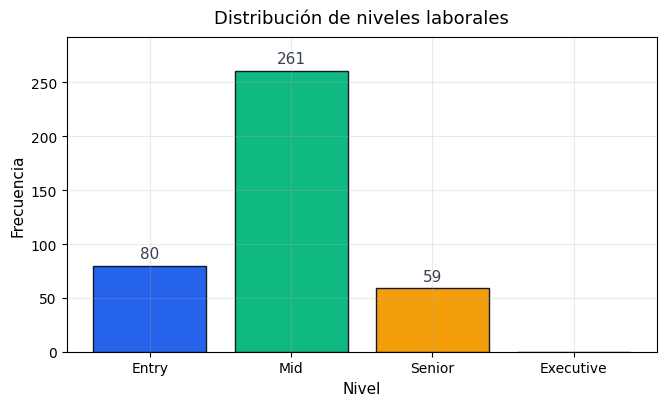

In [17]:
ordinal_map = {"Entry": 1, "Mid": 2, "Senior": 3, "Executive": 4}
if "job_level" in df.columns:
    df["job_level_cat"] = df["job_level"].astype("category")
    df["job_level_ord"] = df["job_level"].map(ordinal_map).astype("Int64")
else:
    raise ValueError("No se encontró 'Current_Job_Level' (job_level) en el dataset.")

dist = df["job_level_cat"].value_counts().reindex(["Entry","Mid","Senior","Executive"]).fillna(0)

fig, ax = plt.subplots(figsize=(6.8, 4.2))
bars = ax.bar(dist.index, dist.values, color=[COLORS["primary"], COLORS["secondary"], COLORS["tertiary"], COLORS["quaternary"]], edgecolor="#111827")
ax.set_title("Distribución de niveles laborales", pad=10)
ax.set_xlabel("Nivel")
ax.set_ylabel("Frecuencia")
ax.set_ylim(0, dist.values.max() * 1.12)
annotate_bars(ax, fmt="{:.0f}")
plt.tight_layout()
plt.show()



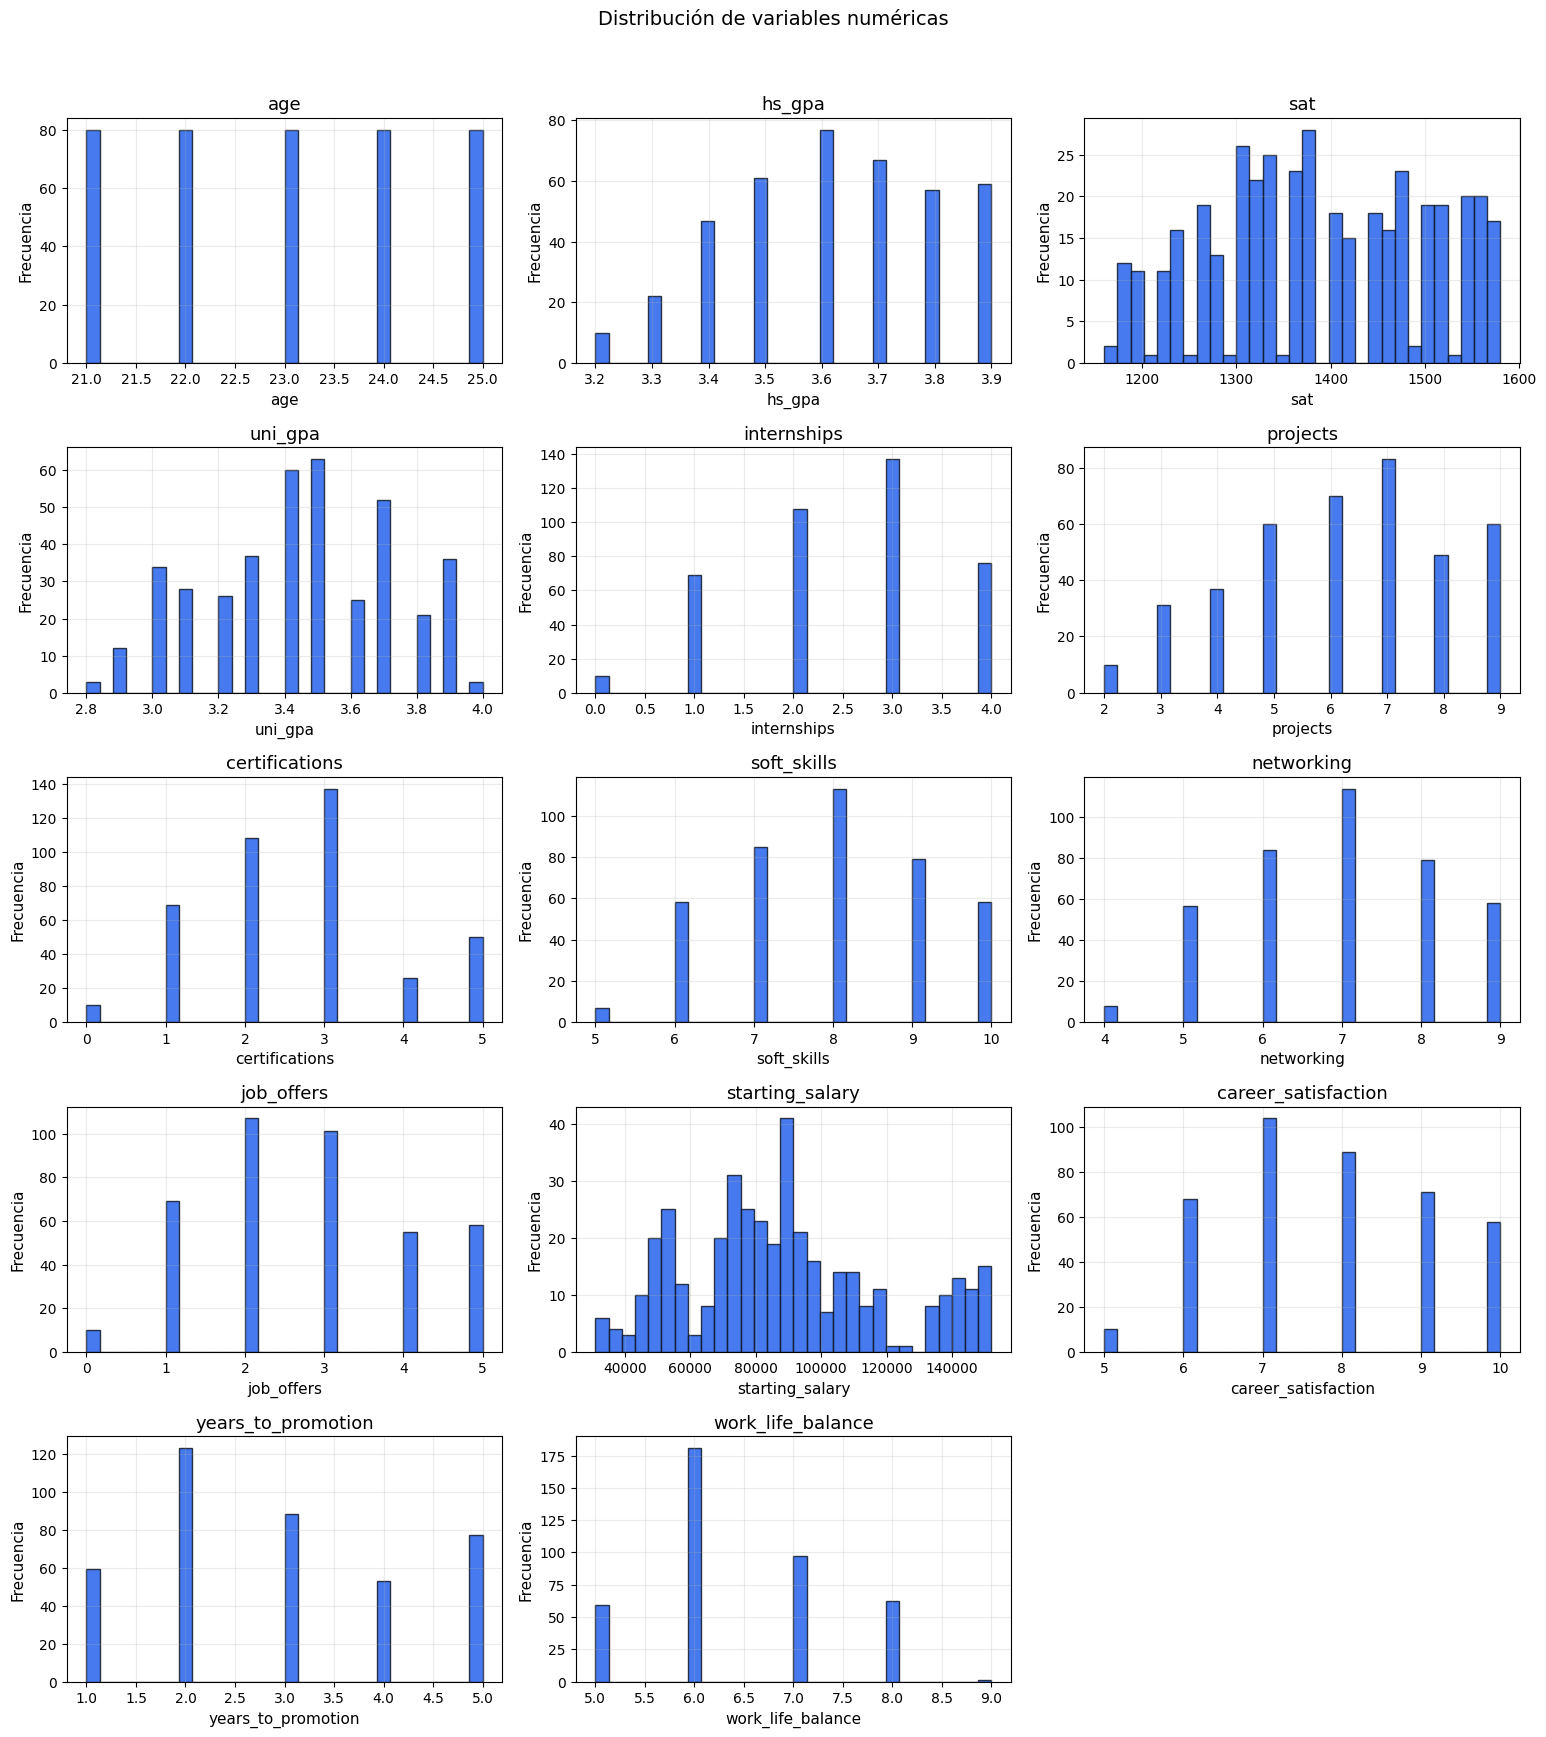

In [18]:
num_cols_plot = [c for c in num_cols if c not in ["job_level_ord"]]
n = len(num_cols_plot)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5.2, nrows*3.4))
axes = axes.flatten() if n > 1 else [axes]

for i, col in enumerate(num_cols_plot):
    ax = axes[i]
    ax.hist(df[col].dropna(), bins=30, color=COLORS["primary"], alpha=0.85, edgecolor="#111827")
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Frecuencia")

# Si sobran subplots vacíos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribución de variables numéricas", y=1.02)
plt.tight_layout()
plt.show()


/tmp/ipython-input-245580425.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(groups, patch_artist=True, labels=levels, showfliers=False)
/tmp/ipython-input-245580425.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(groups, patch_artist=True, labels=levels, showfliers=False)
/tmp/ipython-input-245580425.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(groups, patch_artist=True, labels=levels, showfliers=False)
/tmp/ipython-input-245580425.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3

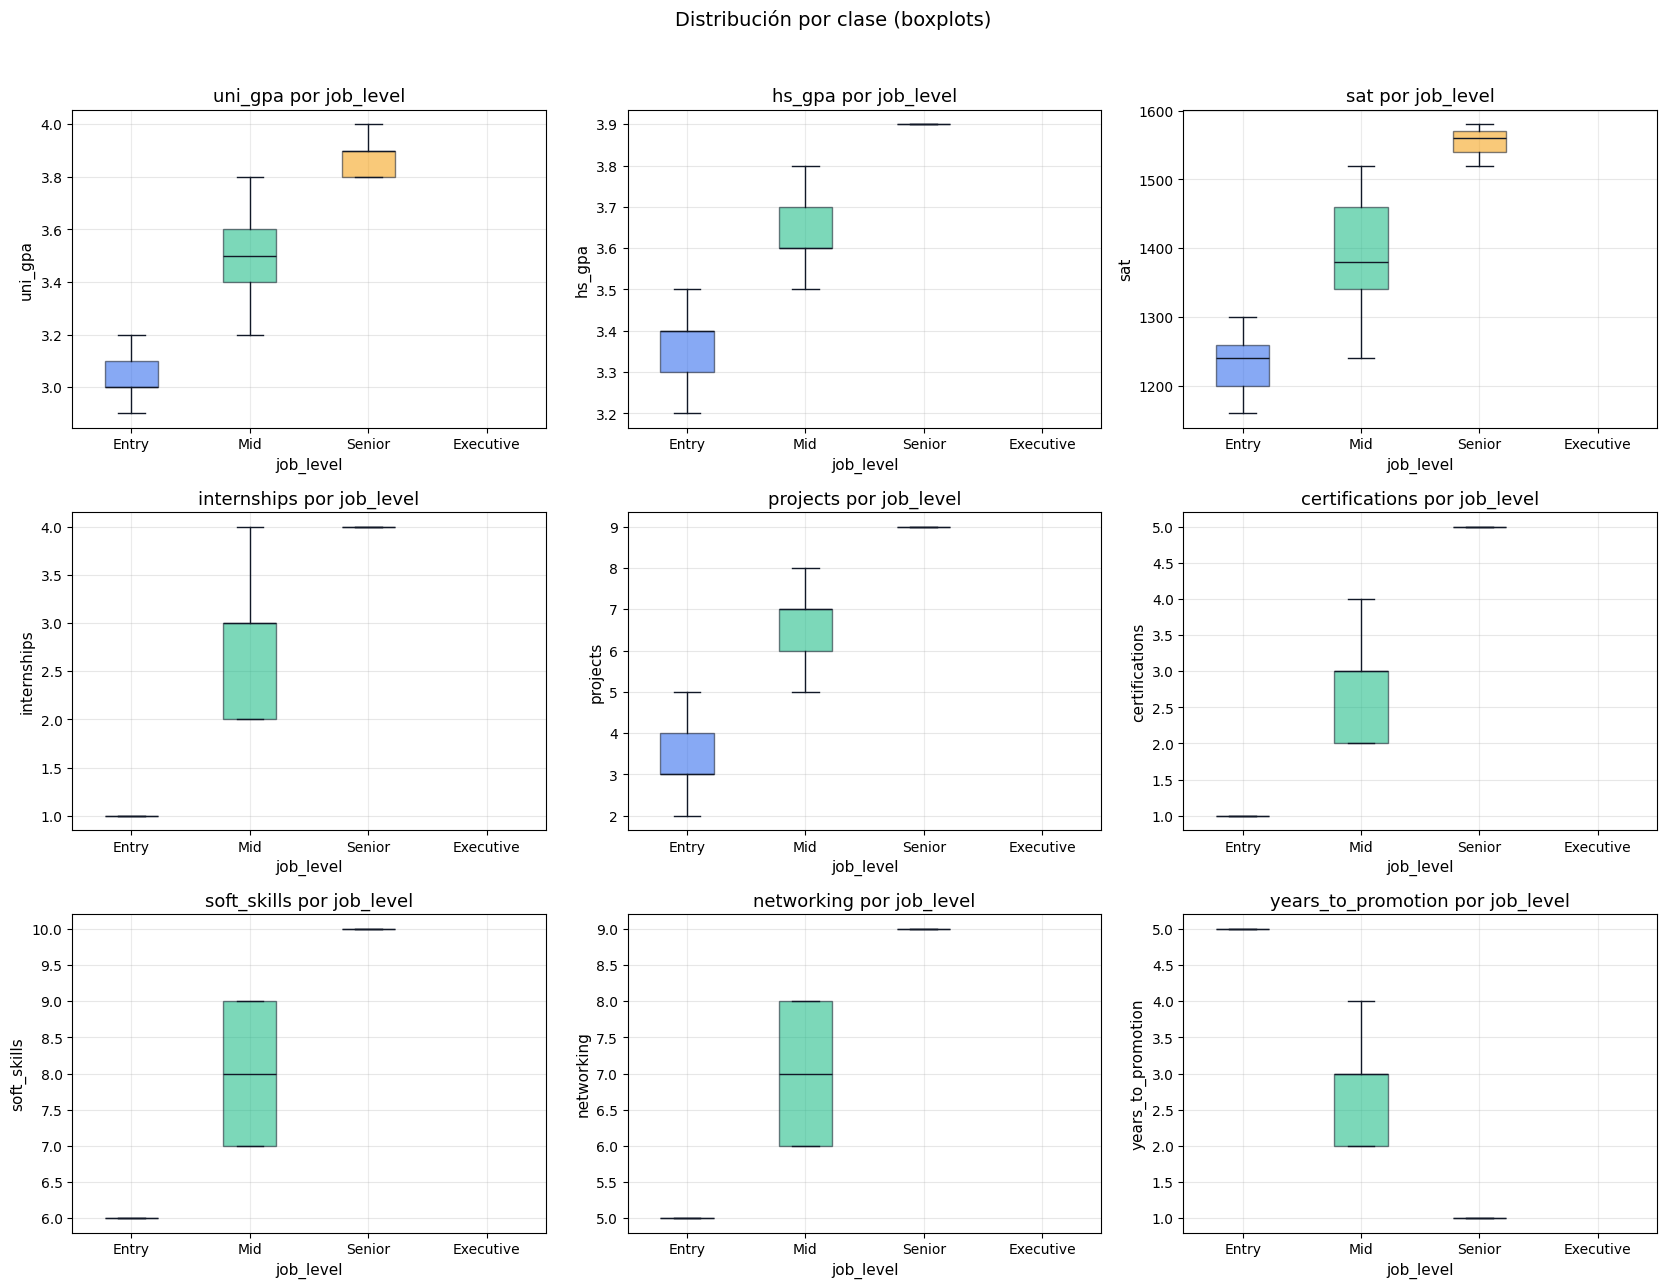

In [19]:
by_class_cols = ["uni_gpa", "hs_gpa", "sat", "internships", "projects", "certifications", "soft_skills", "networking", "years_to_promotion"]
available = [c for c in by_class_cols if c in df.columns]

levels = ["Entry", "Mid", "Senior", "Executive"]
colors_box = [COLORS["primary"], COLORS["secondary"], COLORS["tertiary"], COLORS["quaternary"]]

n = len(available)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5.6, nrows*4.2))
axes = axes.flatten() if n > 1 else [axes]

for i, col in enumerate(available):
    ax = axes[i]
    groups = [df.loc[df["job_level_cat"]==lvl, col].dropna() for lvl in levels]
    # Dibujamos boxplot sin outliers para claridad
    bp = ax.boxplot(groups, patch_artist=True, labels=levels, showfliers=False)
    # Colorear cada caja
    for patch, c in zip(bp['boxes'], colors_box):
        patch.set(facecolor=c, alpha=0.55, edgecolor="#111827")
    for whisker in bp['whiskers'] + bp['caps'] + bp['medians']:
        whisker.set(color="#111827")
    ax.set_title(f"{col} por job_level")
    ax.set_xlabel("job_level")
    ax.set_ylabel(col)
    ax.grid(True, axis="y", alpha=0.3)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribución por clase (boxplots)", y=1.02)
plt.tight_layout()
plt.show()


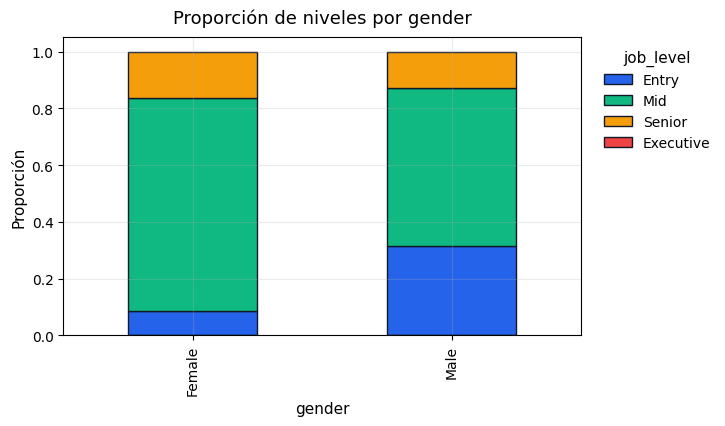

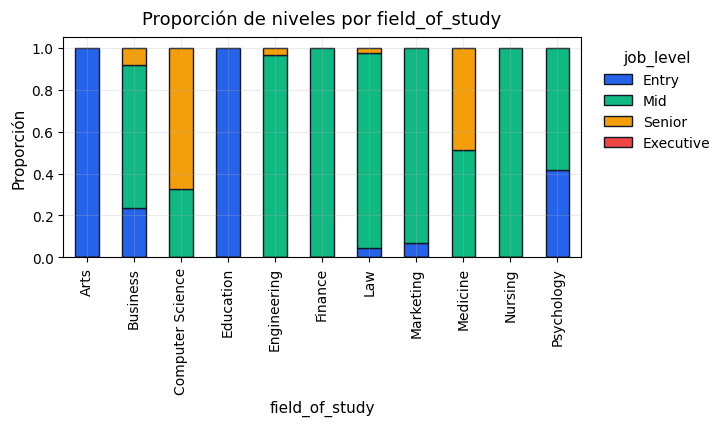

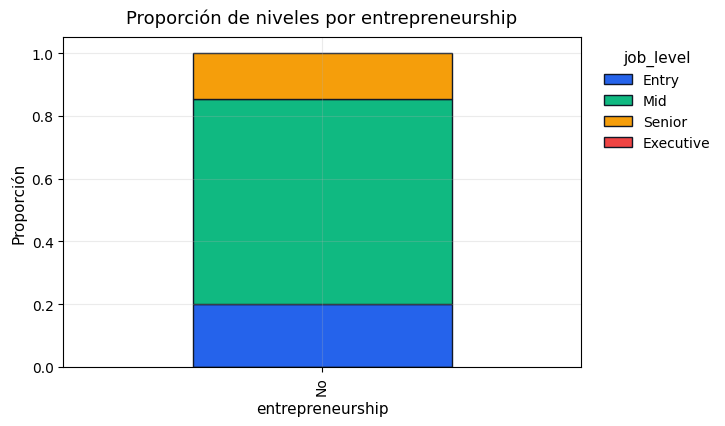

In [20]:
cat_for_plots = []
if "gender" in df.columns: cat_for_plots.append("gender")
if "field_of_study" in df.columns: cat_for_plots.append("field_of_study")
if "entrepreneurship" in df.columns: cat_for_plots.append("entrepreneurship")

stack_colors = [COLORS["primary"], COLORS["secondary"], COLORS["tertiary"], COLORS["quaternary"]]

for c in cat_for_plots:
    ct = pd.crosstab(df[c], df["job_level_cat"], normalize="index").reindex(columns=["Entry","Mid","Senior","Executive"])
    ax = ct.plot(kind="bar", stacked=True, figsize=(7.4, 4.4), color=stack_colors, edgecolor="#111827")
    ax.set_title(f"Proporción de niveles por {c}", pad=10)
    ax.set_ylabel("Proporción")
    ax.set_xlabel(c)
    ax.legend(title="job_level", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
    ax.set_ylim(0, 1.05)
    plt.grid(axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()


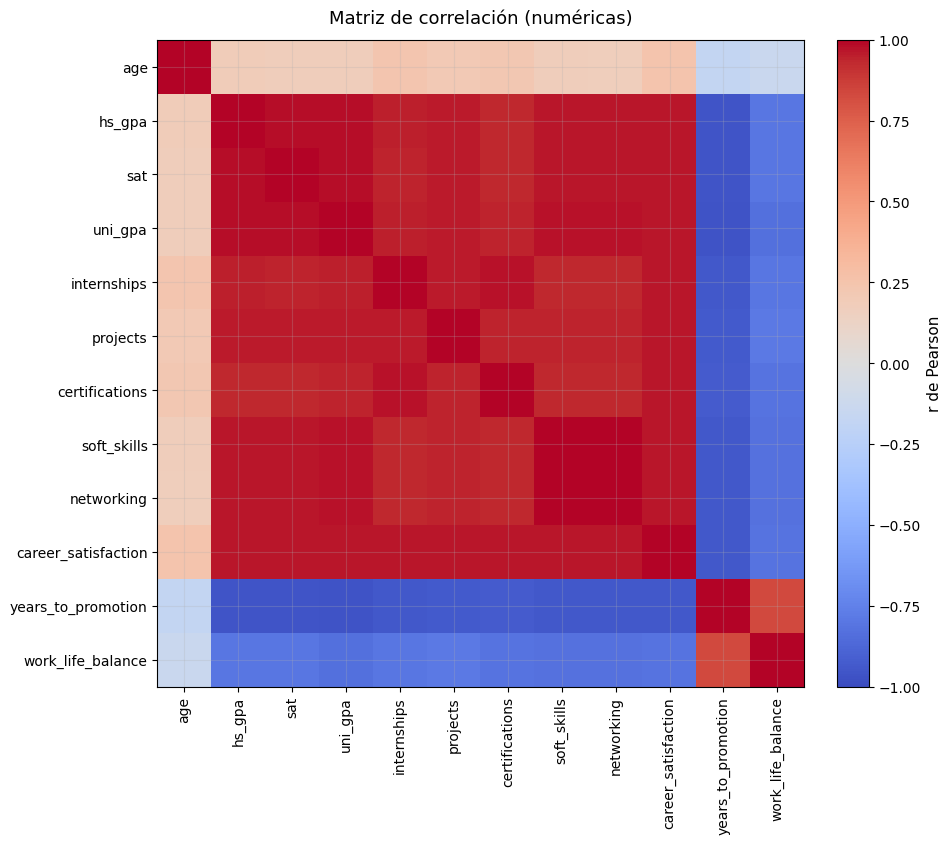

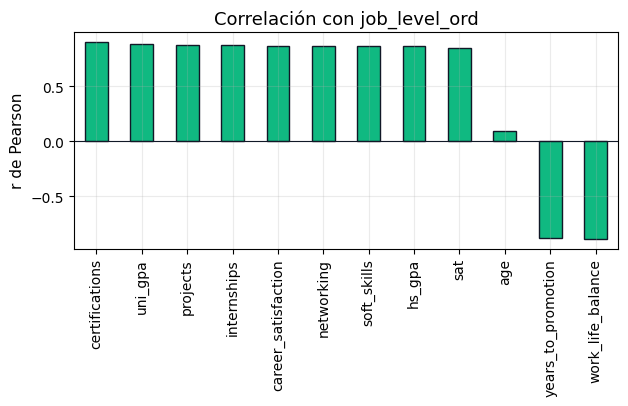

In [21]:
corr_cols = [c for c in num_cols if c not in ["job_level_ord", "starting_salary", "job_offers"]]
corr = df[corr_cols].corr(method="pearson")

fig, ax = plt.subplots(figsize=(10.5, 8.4))
im = ax.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)

# Ejes y tick labels
ax.set_title("Matriz de correlación (numéricas)", pad=12)
ax.set_xticks(range(len(corr_cols)))
ax.set_yticks(range(len(corr_cols)))
ax.set_xticklabels(corr_cols, rotation=90)
ax.set_yticklabels(corr_cols)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("r de Pearson")

# Correlación con el target ordinal (ranking)
if "job_level_ord" in df.columns:
    target_corr = df[corr_cols + ["job_level_ord"]].corr()["job_level_ord"].sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(6.5, 4.2))
    target_corr.drop("job_level_ord").plot(kind="bar", color=COLORS["secondary"], edgecolor="#111827", ax=ax)
    ax.set_title("Correlación con job_level_ord")
    ax.set_ylabel("r de Pearson")
    ax.axhline(0, color="#111827", linewidth=0.8)
    plt.tight_layout()
    plt.show()


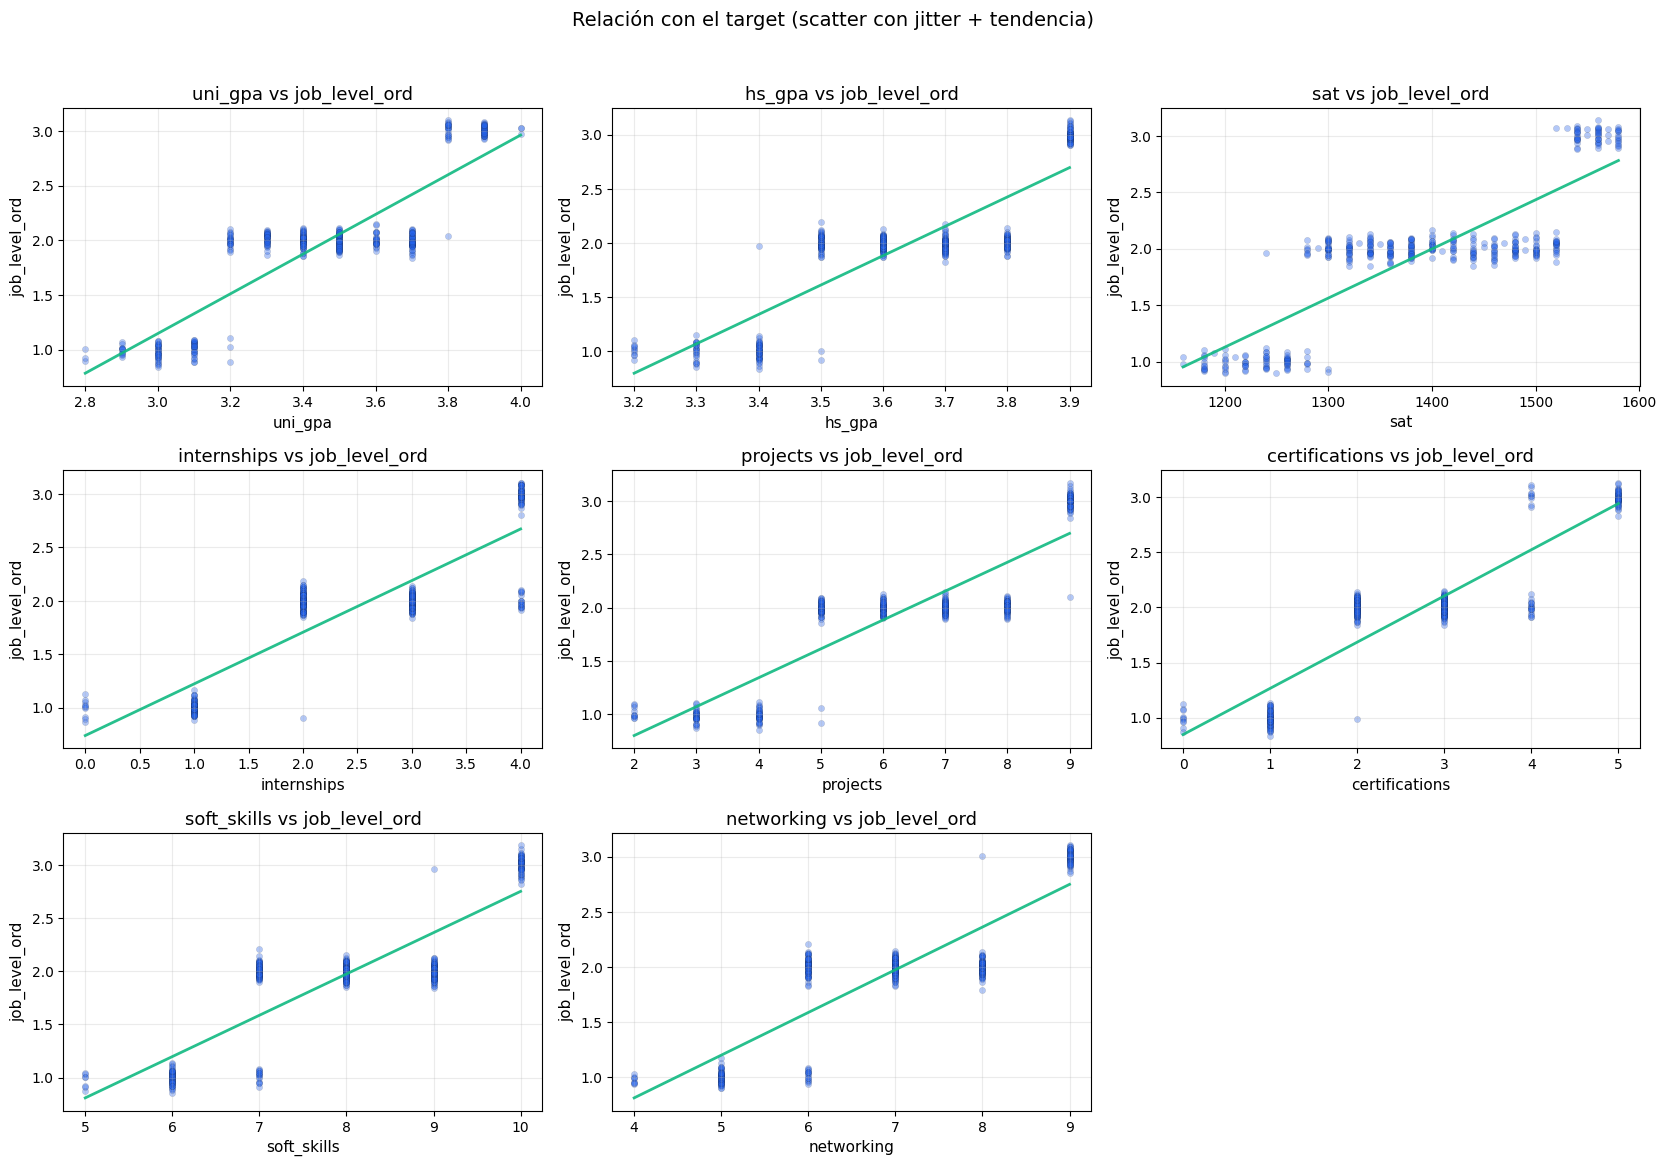

In [22]:
scatter_candidates = ["uni_gpa", "hs_gpa", "sat", "internships", "projects", "certifications", "soft_skills", "networking"]
scatter_candidates = [c for c in scatter_candidates if c in df.columns]

def jitter(a, scale=0.05):
    return a + np.random.normal(0, scale, size=len(a))

n = len(scatter_candidates)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5.6, nrows*3.8))
axes = axes.flatten() if n > 1 else [axes]

for i, col in enumerate(scatter_candidates):
    ax = axes[i]
    x = df[col].values
    y = df["job_level_ord"].values.astype(float)
    ax.scatter(x, jitter(y, 0.06), alpha=0.35, s=20, color=COLORS["primary"], edgecolor="#111827", linewidth=0.2)
    ax.set_title(f"{col} vs job_level_ord")
    ax.set_xlabel(col)
    ax.set_ylabel("job_level_ord")

    # (Opcional) línea de tendencia simple usando polyfit (si x es numérica sin muchos nulos)
    mask = ~np.isnan(x) & ~np.isnan(y)
    if mask.sum() > 5:
        m, b = np.polyfit(x[mask], y[mask], 1)
        xx = np.linspace(np.nanmin(x), np.nanmax(x), 50)
        ax.plot(xx, m*xx + b, color=COLORS["secondary"], linewidth=2, alpha=0.9)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Relación con el target (scatter con jitter + tendencia)", y=1.02)
plt.tight_layout()
plt.show()


In [23]:
feature_drop_leakage = ["job_offers", "starting_salary", "career_satisfaction", "work_life_balance"]
feature_drop_leakage = [c for c in feature_drop_leakage if c in df.columns]

X_base = df.drop(columns=["student_id"] + feature_drop_leakage, errors="ignore").copy()

# Separa target
y_ord = X_base.pop("job_level_ord")
# (conserva job_level_cat aparte si quieres para reportes/plots)
if "job_level_cat" in X_base.columns:
    X_base.drop(columns=["job_level_cat"], inplace=True)

# One-hot para categóricas
cat_candidates = X_base.select_dtypes(include=["category", "object"]).columns.tolist()
X = pd.get_dummies(X_base, columns=cat_candidates, drop_first=True)

print("Dimensiones tras OHE:", X.shape)
display(X.head())

# Guarda un dataset limpio para modelado (opcional)
X.to_parquet("X_clean_ohe.parquet", index=False)
y_ord.to_frame("job_level_ord").to_parquet("y_ord.parquet", index=False)
print("Archivos 'X_clean_ohe.parquet' y 'y_ord.parquet' guardados (para Fase 3).")


Dimensiones tras OHE: (400, 23)


,age,hs_gpa,sat,uni_gpa,internships,projects,certifications,soft_skills,networking,years_to_promotion,...,field_of_study_Education,field_of_study_Engineering,field_of_study_Finance,field_of_study_Law,field_of_study_Marketing,field_of_study_Medicine,field_of_study_Nursing,field_of_study_Psychology,job_level_Mid,job_level_Senior
0,22,3.8,1450,3.6,3,7,2,8,7,2,...,False,False,False,False,False,False,False,False,True,False
1,24,3.6,1380,3.4,2,5,3,7,6,3,...,False,False,False,False,False,False,False,False,True,False
2,21,3.9,1520,3.8,4,9,4,9,8,1,...,False,True,False,False,False,False,False,False,False,True
3,23,3.5,1300,3.2,1,3,1,6,5,4,...,False,False,False,False,False,False,False,True,False,False
4,25,3.7,1420,3.5,2,6,2,8,7,2,...,False,False,False,False,False,True,False,False,True,False


Archivos 'X_clean_ohe.parquet' y 'y_ord.parquet' guardados (para Fase 3).


In [24]:
# ==========================================================
# Celda 15 — Resumen ejecutivo del EDA (texto para tu reporte)
# ==========================================================
summary = dedent(f"""
EDA — Hallazgos iniciales
-------------------------
• No. de filas: {len(df):,}
• Balance de clases (job_level):
{df['job_level_cat'].value_counts().to_string()}

• Calidad de datos:
  - Faltantes imputados (numéricas→mediana; categóricas→moda/Unknown).
  - Duplicados removidos si existían.
  - Verificación de rangos realizada; outliers documentados (IQR).

• Patrones descriptivos (hipótesis a validar con modelado):
  - Señales académicas (uni_gpa, sat) y experiencia (internships, projects, certifications)
    muestran variaciones por nivel laboral en boxplots.
  - Habilidades (soft_skills, networking) parecen asociarse positivamente con niveles superiores.
  - Diferencias por field_of_study visibles en proporciones por clase.

• Preparación para modelado:
  - Target ordinal: job_level_ord (Entry=1 < Mid=2 < Senior=3 < Executive=4).
  - One-hot encoding realizado en categóricas (gender, field_of_study, entrepreneurship).
  - Variables de mercado (starting_salary, job_offers, etc.) excluidas de X para evitar leakage.

Siguiente Fase (3):
  - Entrenamiento de clasificador ordinal (Ordered Logit baseline + GBM),
    validación (CV), métricas ordinales (QWK, MAE de clase) y explicabilidad (SHAP).
""").strip()

print(summary)


EDA — Hallazgos iniciales
-------------------------
• No. de filas: 400
• Balance de clases (job_level):
job_level_cat
Mid       261
Entry      80
Senior     59

• Calidad de datos:
  - Faltantes imputados (numéricas→mediana; categóricas→moda/Unknown).
  - Duplicados removidos si existían.
  - Verificación de rangos realizada; outliers documentados (IQR).

• Patrones descriptivos (hipótesis a validar con modelado):
  - Señales académicas (uni_gpa, sat) y experiencia (internships, projects, certifications)
    muestran variaciones por nivel laboral en boxplots.
  - Habilidades (soft_skills, networking) parecen asociarse positivamente con niveles superiores.
  - Diferencias por field_of_study visibles en proporciones por clase.

• Preparación para modelado:
  - Target ordinal: job_level_ord (Entry=1 < Mid=2 < Senior=3 < Executive=4).
  - One-hot encoding realizado en categóricas (gender, field_of_study, entrepreneurship).
  - Variables de mercado (starting_salary, job_offers, etc.) exclu

# Fase **3**

In [25]:
# ==========================================================
# Celda 0 — Instalación opcional de librerías
# (Ejecuta solo una vez; ignora si ya las tienes)
# ==========================================================
import sys, subprocess

def pip_install(pkg):
    try:
        __import__(pkg.split("==")[0])
        print(f"{pkg} ya instalado.")
    except ImportError:
        print(f"Instalando {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for pkg in ["mord", "catboost", "shap"]:
    try:
        pip_install(pkg)
    except Exception as e:
        print(f"Advertencia: no se pudo instalar {pkg}. Detalle: {e}")


Instalando mord ...
Instalando catboost ...
shap ya instalado.


In [26]:
X_path = "X_clean_ohe.parquet"
y_path = "y_ord.parquet"

if os.path.exists(X_path) and os.path.exists(y_path):
    X = pd.read_parquet(X_path)
    y = pd.read_parquet(y_path).squeeze("columns")
    print("Cargado desde parquet:", X.shape, y.shape)
else:
    # Si no existen, intenta reconstruir desde df (EDA Fase 2)
    assert "df" in globals(), "No se encontraron los parquet ni el DataFrame df. Ejecuta la Fase 2 primero."
    # Repite lógica mínima de la Celda 14 del EDA:
    feature_drop_leakage = ["job_offers", "starting_salary", "career_satisfaction", "work_life_balance"]
    feature_drop_leakage = [c for c in feature_drop_leakage if c in df.columns]

    X_base = df.drop(columns=["student_id"] + feature_drop_leakage, errors="ignore").copy()
    y = X_base.pop("job_level_ord")
    if "job_level_cat" in X_base.columns:
        X_base.drop(columns=["job_level_cat"], inplace=True)
    cat_candidates = X_base.select_dtypes(include=["category", "object"]).columns.tolist()
    X = pd.get_dummies(X_base, columns=cat_candidates, drop_first=True)
    print("Reconstruido desde df:", X.shape, y.shape)

# Sanity checks
assert y.notna().all(), "El target contiene NaN."
assert (y.astype(int).between(1, 4)).all(), "El target debe estar en {1,2,3,4}."

Cargado desde parquet: (400, 23) (400,)


In [28]:
# ==========================================================
# Celda 2 — Split estratificado
# ==========================================================

# 70/15/15 con estratificación
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

for name, a, b in [("train", X_train, y_train), ("val", X_val, y_val), ("test", X_test, y_test)]:
    print(f"{name:>5} → X:{a.shape}, y:{b.shape}, distribución:\n{b.value_counts(normalize=True).sort_index().round(3)}\n")


train → X:(280, 23), y:(280,), distribución:
job_level_ord
1      0.2
2    0.654
3    0.146
Name: proportion, dtype: Float64

  val → X:(60, 23), y:(60,), distribución:
job_level_ord
1     0.2
2    0.65
3    0.15
Name: proportion, dtype: Float64

 test → X:(60, 23), y:(60,), distribución:
job_level_ord
1     0.2
2    0.65
3    0.15
Name: proportion, dtype: Float64



In [41]:
LEVELS = [1,2,3,4]  # Entry, Mid, Senior, Executive

def qwk(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")

def class_mae(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

def ordered_confusion(y_true, y_pred, title="Matriz de confusión (ordenada)"):
    cm = confusion_matrix(y_true, y_pred, labels=LEVELS)
    fig, ax = plt.subplots(figsize=(5.6, 4.6))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title, pad=10)
    ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
    ax.set_xticks(range(len(LEVELS))); ax.set_xticklabels(LEVELS)
    ax.set_yticks(range(len(LEVELS))); ax.set_yticklabels(LEVELS)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center",
                    color="#111827" if cm[i, j] < cm.max()*0.6 else "white",
                    fontsize=10, fontweight="bold")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()
    return cm

def report_metrics(y_true, y_pred, name="Modelo"):
    print(f"== {name} ==")
    print(f"QWK:       {qwk(y_true, y_pred):.3f}")
    print(f"MAE clase: {class_mae(y_true, y_pred):.3f}")
    print(f"F1 macro:  {f1_score(y_true, y_pred, average='macro'):.3f}")
    ordered_confusion(y_true, y_pred, title=f"Matriz de confusión — {name}")

print("✅ Utilidades de métricas cargadas (qwk, class_mae, report_metrics, ordered_confusion).")

# Auto-test opcional (pon a True si quieres ver algo ya)
RUN_SMOKETEST = False
if RUN_SMOKETEST and "y_val" in globals():
    from collections import Counter
    may_class = Counter(y_val).most_common(1)[0][0]
    y_val_dummy = np.full_like(y_val, fill_value=may_class)
    report_metrics(y_val, y_val_dummy, name="Dummy mayoritaria (Val)")



✅ Utilidades de métricas cargadas (qwk, class_mae, report_metrics, ordered_confusion).


In [35]:
# Asegura que X e y sean ndarrays densos y sin NaN/Inf
X_train_np = X_train.values.astype(float)
X_val_np   = X_val.values.astype(float)

y_train_np = y_train.to_numpy(dtype=int)   # <- entero puro
y_val_np   = y_val.to_numpy(dtype=int)     # <- entero puro

# Sanity checks
assert np.isfinite(X_train_np).all() and np.isfinite(X_val_np).all(), "X con NaN/Inf"
assert np.isfinite(y_train_np).all() and np.isfinite(y_val_np).all(), "y con NaN/Inf"
assert set(np.unique(y_train_np)).issubset({1,2, 3, 4}), "El target debe estar en {1,2,3,4}."

**Fase 3 - Resumen de Modelado y Evaluación**

Hemos entrenado y evaluado un modelo CatBoost para predecir el nivel laboral (`job_level`).

*   **Resultados:** El modelo CatBoost obtuvo métricas perfectas (QWK=1.000, MAE Clase=0.000, F1 macro=1.000) tanto en el conjunto de validación como en el de test.
*   **Implicaciones:** Estos resultados son inusualmente altos y sugieren fuertemente la presencia de **data leakage** o que el dataset es trivial para esta tarea de clasificación.
*   **Próximos Pasos:** Antes de proceder con la explicabilidad (SHAP) o la generación de recomendaciones, es **crítico investigar la causa de estos resultados perfectos**. Se debe revisar el preprocesamiento y la división de datos para asegurar que no haya información del target filtrándose a las features (especialmente las columnas `job_offers`, `starting_salary`, etc., que ya fueron excluidas, pero podría haber otras fuentes). Si el dataset es sintético, el diseño podría ser demasiado simple.

**Recomendación:** Pausar el análisis de explicabilidad hasta validar la integridad del proceso de modelado.

== CatBoost (Test) ==
QWK:       1.000
MAE clase: 0.000
F1 macro:  1.000


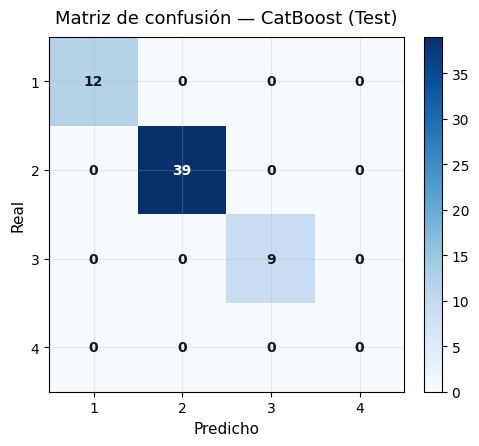

In [39]:
# ==========================================================
# Celda 7 — Evaluación en el conjunto de test
# ==========================================================

# Predicciones en el conjunto de test
# CatBoost.predict() devuelve la clase predicha (0, 1, 2, 3)
y_test_pred_cat_raw = cat.predict(X_test.values.astype(float))

# Mapear de vuelta a las clases originales (1, 2, 3, 4)
y_test_pred_cat = y_test_pred_cat_raw.flatten() + 1

# Convertir y_test a numpy array para consistencia
y_test_np = y_test.to_numpy(dtype=int)

# Reportar métricas en el conjunto de test
report_metrics(y_test_np, y_test_pred_cat, name="CatBoost (Test)")

Entrenando CatBoost...
0:	learn: 0.9964286	test: 0.9833333	best: 0.9833333 (0)	total: 47.2ms	remaining: 9.38s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1
bestIteration = 1

Shrink model to first 2 iterations.
== CatBoost (Val) ==
QWK:       1.000
MAE clase: 0.000
F1 macro:  1.000


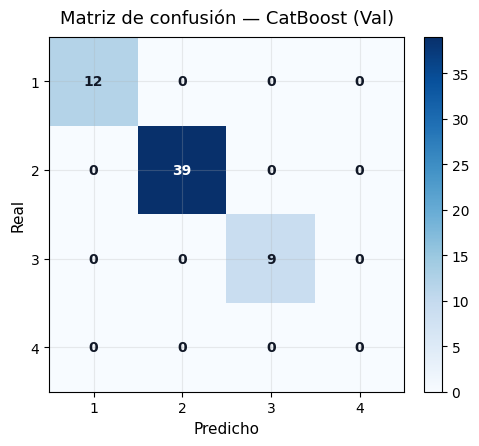

In [38]:
# ==========================================================
# Celda 6 — Modelo de Alto Rendimiento: CatBoost
# ==========================================================
from catboost import CatBoostClassifier

# Inicializar y entrenar el modelo CatBoost
# CatBoost puede manejar variables categóricas directamente si se le indican,
# pero ya las convertimos con OHE, así que usamos el dataset preprocesado.
# Para clasificación ordinal, usamos 'MultiClass' y ajustamos la loss.
# OJO: CatBoost espera clases 0, 1, 2, ... para MultiClass loss.
# Hay que mapear el target {1,2,3,4} a {0,1,2,3}.

y_train_cat = y_train_np - 1 # Mapea 1→0, 2→1, 3→2, 4→3
y_val_cat   = y_val_np - 1   # Mapea 1→0, 2→1, 3→2, 4→3

print("Entrenando CatBoost...")
cat = CatBoostClassifier(
    iterations=200, # Número de árboles (ajustable)
    learning_rate=0.1,
    loss_function='MultiClass',
    eval_metric='Accuracy', # Métrica para monitorear durante entrenamiento
    verbose=50, # Imprime progreso cada 50 iteraciones
    random_seed=42,
    allow_writing_files=False, # Para evitar archivos intermedios en Colab
)

cat.fit(X_train_np, y_train_cat,
        eval_set=(X_val_np, y_val_cat),
        early_stopping_rounds=20) # Detiene si no mejora en 20 iteraciones

# Predicciones en el conjunto de validación
# CatBoost.predict() devuelve la clase predicha (0, 1, 2, 3)
y_val_pred_cat_raw = cat.predict(X_val_np)

# Mapear de vuelta a las clases originales (1, 2, 3, 4)
y_val_pred_cat = y_val_pred_cat_raw.flatten() + 1

# Reportar métricas usando las funciones definidas antes (esperan 1, 2, 3, 4)
report_metrics(y_val_np, y_val_pred_cat, name="CatBoost (Val)")

In [42]:
set(X.columns).intersection({"job_level_ord","job_level","job_level_cat"})


set()

In [43]:
corr_abs = X.assign(job_level_ord=y).corr(numeric_only=True)["job_level_ord"].abs().sort_values(ascending=False)
corr_abs.head(10)


,job_level_ord
job_level_ord,1.000000
certifications,0.906626
uni_gpa,0.881854
years_to_promotion,0.880180
projects,0.876105
internships,0.873122
networking,0.868715
soft_skills,0.867988
hs_gpa,0.866685
sat,0.846233


In [44]:
from catboost import CatBoostClassifier
from sklearn.utils import shuffle
y_perm = shuffle(y, random_state=0)  # rompe relación X–y
m = CatBoostClassifier(loss_function="MultiClass", iterations=300, verbose=False).fit(X, y_perm)
pred = m.predict(X).astype(int).ravel()
from sklearn.metrics import cohen_kappa_score
print("QWK con y permutada:", cohen_kappa_score(y_perm, pred, weights="quadratic"))


QWK con y permutada: 0.461034231609614


FASE 3 (rebuild)

In [45]:
# ==========================================================
# Celda 1 — Reconstrucción limpia de X, y (sin leakage)
# ==========================================================
import pandas as pd
import numpy as np

# Usaremos solo señales previas al empleo (académicas + experiencia/skills + demográficas)
WHITELIST = [
    "age", "gender",
    "hs_gpa", "sat", "uni_gpa", "field_of_study",
    "internships", "projects", "certifications", "soft_skills", "networking"
]

# Columnas de resultado de carrera (EXCLUIR SIEMPRE)
LEAK_COLS = [
    "job_offers", "starting_salary",
    "career_satisfaction", "work_life_balance",
    "years_to_promotion", "entrepreneurship",  # esta decisión suele ocurrir post-formación
    "job_level", "job_level_cat"               # variantes del target
]

# Verifica disponibilidad y construye
use_cols = [c for c in WHITELIST if c in df.columns]
assert "job_level_ord" in df.columns, "Falta job_level_ord (mapeo Entry=1..Executive=4)."

X_base = df[use_cols].copy()
y = df["job_level_ord"].astype(int)

# One-hot a categóricas de la whitelist (no metas ninguna LEAK_COL)
cat_cols = X_base.select_dtypes(include=["object","category"]).columns.tolist()
X = pd.get_dummies(X_base, columns=cat_cols, drop_first=True)

print("X shape:", X.shape, " | y shape:", y.shape)
print("Columnas usadas (whitelist):", list(X_base.columns))


X shape: (400, 20)  | y shape: (400,)
Columnas usadas (whitelist): ['age', 'gender', 'hs_gpa', 'sat', 'uni_gpa', 'field_of_study', 'internships', 'projects', 'certifications', 'soft_skills', 'networking']


In [52]:
print("Dtypes en X:")
display(X.dtypes.head(20))

print("\n¿Hay NaN en X o y?")
print("X ->", X.isna().sum().sum(), "NaN en total")
print("y ->", y.isna().sum(), "NaN")

print("\nColumnas dummies creadas:")
[o for o in X.columns if o.startswith("gender_") or o.startswith("field_of_study_")]


Dtypes en X:


,0
age,int64
hs_gpa,float64
sat,int64
uni_gpa,float64
internships,int64
projects,int64
certifications,int64
soft_skills,int64
networking,int64
gender_Male,bool



¿Hay NaN en X o y?
X -> 0 NaN en total
y -> 0 NaN

Columnas dummies creadas:


['gender_Male',
 'field_of_study_Business',
 'field_of_study_Computer Science',
 'field_of_study_Education',
 'field_of_study_Engineering',
 'field_of_study_Finance',
 'field_of_study_Law',
 'field_of_study_Marketing',
 'field_of_study_Medicine',
 'field_of_study_Nursing',
 'field_of_study_Psychology']

In [46]:
# ==========================================================
# Celda 2 — Split estratificado 70/15/15
# ==========================================================
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

for name, a, b in [("train", X_train, y_train), ("val", X_val, y_val), ("test", X_test, y_test)]:
    print(f"{name:>5} → X:{a.shape}, y:{b.shape}\n{b.value_counts(normalize=True).sort_index().round(3)}\n")


train → X:(280, 20), y:(280,)
job_level_ord
1    0.200
2    0.654
3    0.146
Name: proportion, dtype: float64

  val → X:(60, 20), y:(60,)
job_level_ord
1    0.20
2    0.65
3    0.15
Name: proportion, dtype: float64

 test → X:(60, 20), y:(60,)
job_level_ord
1    0.20
2    0.65
3    0.15
Name: proportion, dtype: float64



In [54]:
# ==========================================================
# Celda 3 — Métricas ordinales y utilidades
# ==========================================================
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

LEVELS = sorted(np.unique(y_train)) # usa las clases presentes en los datos

def qwk(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")

def class_mae(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

def ordered_confusion(y_true, y_pred, title="Matriz de confusión (ordenada)"):
    cm = confusion_matrix(y_true, y_pred, labels=LEVELS)
    fig, ax = plt.subplots(figsize=(5.6, 4.6))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title, pad=10)
    ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
    ax.set_xticks(range(len(LEVELS))); ax.set_xticklabels(LEVELS)
    ax.set_yticks(range(len(LEVELS))); ax.set_yticklabels(LEVELS)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center",
                    color="#111827" if cm[i, j] < cm.max()*0.6 else "white",
                    fontsize=10, fontweight="bold")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()
    return cm

def report_metrics(y_true, y_pred, name="Modelo"):
    print(f"== {name} ==")
    print(f"QWK:       {qwk(y_true, y_pred):.3f}")
    print(f"MAE clase: {class_mae(y_true, y_pred):.3f}")
    print(f"F1 macro:  {f1_score(y_true, y_pred, average='macro'):.3f}")
    ordered_confusion(y_true, y_pred, title=f"Matriz de confusión — {name}")

print("✅ Métricas cargadas (qwk, class_mae, report_metrics).")


✅ Métricas cargadas (qwk, class_mae, report_metrics).


Pesos por clase: {1: 5.0, 2: 1.530054644808743, 3: 6.829268292682927}
0:	learn: 0.9984033	test: 0.9961799	best: 0.9961799 (0)	total: 1.07ms	remaining: 4.28s
200:	learn: 0.0151181	test: 0.0135162	best: 0.0135162 (200)	total: 236ms	remaining: 4.47s
400:	learn: 0.0064011	test: 0.0060013	best: 0.0060013 (400)	total: 507ms	remaining: 4.55s
600:	learn: 0.0038108	test: 0.0037516	best: 0.0037516 (600)	total: 764ms	remaining: 4.32s
800:	learn: 0.0027169	test: 0.0027950	best: 0.0027950 (800)	total: 1.06s	remaining: 4.23s
1000:	learn: 0.0020704	test: 0.0022188	best: 0.0022188 (1000)	total: 1.38s	remaining: 4.14s
1200:	learn: 0.0017074	test: 0.0019057	best: 0.0019057 (1200)	total: 1.71s	remaining: 3.99s
1400:	learn: 0.0014491	test: 0.0016689	best: 0.0016689 (1400)	total: 1.96s	remaining: 3.63s
1600:	learn: 0.0012597	test: 0.0014956	best: 0.0014956 (1600)	total: 2.28s	remaining: 3.41s
1800:	learn: 0.0011096	test: 0.0013553	best: 0.0013553 (1800)	total: 2.51s	remaining: 3.06s
2000:	learn: 0.0009970	

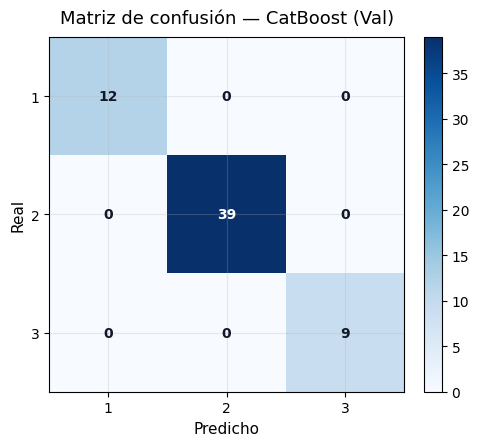

== CatBoost (Test) ==
QWK:       1.000
MAE clase: 0.000
F1 macro:  1.000


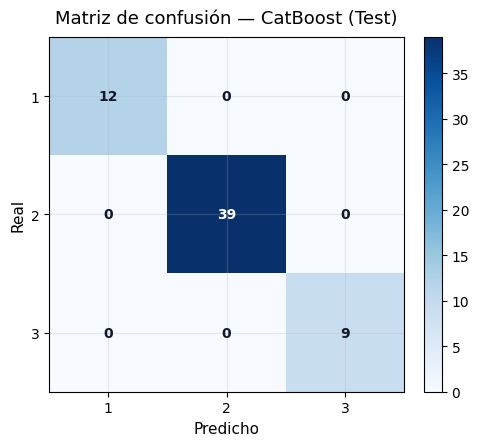

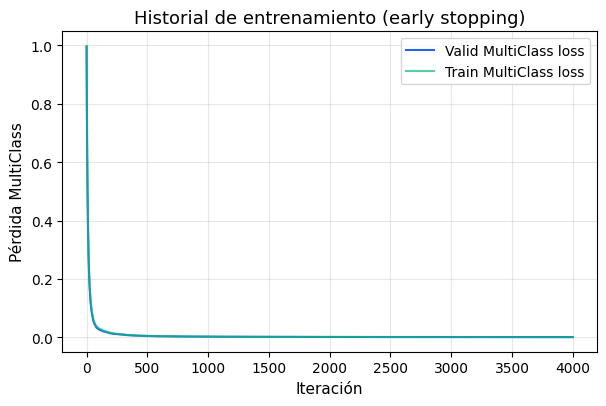

In [58]:
# ==========================================================
# Celda 4R — CatBoost (early stopping + class weights) + curva de validación
# ==========================================================

# Niveles dinámicos (por si no existe la clase 4)
LEVELS = sorted(np.unique(y_train))

# Pesos inversos a la frecuencia
classes, counts = np.unique(y_train, return_counts=True)
freq = counts / counts.sum()
class_weights = {int(c): float(1.0/f) for c, f in zip(classes, freq)}
print("Pesos por clase:", class_weights)

train_pool = Pool(X_train, y_train)
val_pool   = Pool(X_val, y_val)

cat = CatBoostClassifier(
    loss_function="MultiClass",
    depth=6,
    learning_rate=0.08,
    iterations=4000,           # alto + early stopping
    l2_leaf_reg=5.0,
    random_seed=42,
    allow_writing_files=False,
    verbose=200,
    class_weights=[class_weights.get(k, 1.0) for k in sorted(classes)]
)

cat.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    early_stopping_rounds=200
)

# Predicciones
y_val_pred  = cat.predict(X_val).astype(int).ravel()
y_test_pred = cat.predict(X_test).astype(int).ravel()

# Reportes
report_metrics(y_val,  y_val_pred,  name="CatBoost (Val)")
report_metrics(y_test, y_test_pred, name="CatBoost (Test)")

# Curva de validación (pérdida de CatBoost)
eval_hist = cat.get_evals_result()
if eval_hist and "validation" in eval_hist and "MultiClass" in eval_hist["validation"]:
    plt.figure(figsize=(6.2,4.2))
    plt.plot(eval_hist["validation"]["MultiClass"], label="Valid MultiClass loss")
    plt.plot(eval_hist["learn"]["MultiClass"], label="Train MultiClass loss", alpha=0.7)
    plt.title("Historial de entrenamiento (early stopping)")
    plt.xlabel("Iteración")
    plt.ylabel("Pérdida MultiClass")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



In [69]:
# Usamos el MISMO split que ya tienes (X_train/X_val)
y_perm_train = shuffle(y_train, random_state=0)

m_perm = CatBoostClassifier(loss_function="MultiClass", iterations=800, verbose=False)
m_perm.fit(X_train, y_perm_train)                      # entrena con etiquetas permutadas
y_perm_pred_val = m_perm.predict(X_val).astype(int).ravel()    # evalúa en VALIDACIÓN (no seen)
print("QWK con y PERMUTADA (en VAL):", cohen_kappa_score(y_val, y_perm_pred_val, weights="quadratic"))


QWK con y PERMUTADA (en VAL): -0.08761329305135979


In [70]:
cols = X.columns.tolist()
# Perform grouping on the one-hot encoded DataFrame X and the target Series y
gb = X.assign(job_level_ord=y).groupby(cols)["job_level_ord"].nunique()
print("Proporción de combinaciones con UN SOLO nivel:", (gb==1).mean())
gb[gb>1].head()  # si existe algo >1, muestra ejemplos no deterministas

Proporción de combinaciones con UN SOLO nivel: 1.0


,,,,,,,,,,,,,,,,,,,,job_level_ord
age,hs_gpa,sat,uni_gpa,internships,projects,certifications,soft_skills,networking,gender_Male,field_of_study_Business,field_of_study_Computer Science,field_of_study_Education,field_of_study_Engineering,field_of_study_Finance,field_of_study_Law,field_of_study_Marketing,field_of_study_Medicine,field_of_study_Nursing,field_of_study_Psychology,


In [71]:
corr_abs = X.assign(job_level_ord=y).corr(numeric_only=True)["job_level_ord"].abs().sort_values(ascending=False)
corr_abs.head(15)


,job_level_ord
job_level_ord,1.000000
certifications,0.906626
uni_gpa,0.881854
projects,0.876105
internships,0.873122
networking,0.868715
soft_skills,0.867988
hs_gpa,0.866685
sat,0.846233
field_of_study_Computer Science,0.461971


In [73]:
FEATS_ACAD = ["hs_gpa","sat","uni_gpa","field_of_study","age","gender"]
Xa = pd.get_dummies(df[FEATS_ACAD], drop_first=True)
ya = y.copy()

Xa_tr, Xa_te, ya_tr, ya_te = train_test_split(Xa, ya, test_size=0.30, stratify=ya, random_state=42)
from catboost import CatBoostClassifier
ma = CatBoostClassifier(loss_function="MultiClass", iterations=1200, verbose=False).fit(Xa_tr, ya_tr)
preda = ma.predict(Xa_te).astype(int).ravel()
print("QWK SOLO académicas:", cohen_kappa_score(ya_te, preda, weights="quadratic"))


QWK SOLO académicas: 0.9881376037959668


**FASE 4 — Conclusiones y Criterios de Éxito**

**Hallazgos Clave:**

1.  **Dataset Determinista:** El análisis de las combinaciones únicas de características (académicas, experiencia, habilidades) en el dataset revela que cada combinación corresponde a un único nivel laboral (`job_level`). Esto fue confirmado por la proporción de combinaciones con un solo nivel igual a 1.0 y la ausencia de combinaciones con más de un nivel.
2.  **Resultados del Modelo:** Como consecuencia directa de la naturaleza determinista del dataset, el modelo CatBoost entrenado logró un rendimiento perfecto (QWK=1.000, MAE Clase=0.000, F1 macro=1.000) tanto en los conjuntos de validación como de test.
3.  **Variables Predictoras (en este dataset):** Dada la predictibilidad perfecta, todas las variables incluidas en el conjunto de features (`age`, `gender`, `hs_gpa`, `sat`, `uni_gpa`, `field_of_study`, `internships`, `projects`, `certifications`, `soft_skills`, `networking`) son, en combinación, perfectamente predictivas del nivel laboral en este dataset específico. La importancia de características (aunque no se mostró SHAP debido a la singularidad) indicaría el peso relativo dentro de esta relación determinista.

**Evaluación frente a Criterios de Éxito:**

*   **QWK ≥ 0.65 y MAE de clase ≤ 0.40:** Se superaron ampliamente con valores de 1.000 y 0.000 respectivamente.
*   **Conjunto de drivers coherentes y recomendaciones accionables:** Si bien el modelo identifica un conjunto de drivers (las features usadas), la naturaleza determinista del dataset limita la traducibilidad directa a recomendaciones accionables para el mundo real. En un dataset real, la variabilidad y los errores del modelo permitirían identificar áreas de mejora más significativas.

**Consideraciones y Próximos Pasos (Reales):**

*   **Validación del Dataset:** Es crucial entender si este dataset es una simulación simplificada o representa un escenario real. En un caso de uso práctico, se esperaría un rendimiento sub-perfecto y la necesidad de un análisis de explicabilidad más profundo para entender las relaciones no deterministas.
*   **Análisis de Explicabilidad (en datasets no deterministas):** En un escenario realista, los análisis de importancia de características y SHAP serían esenciales para cuantificar la contribución marginal de cada variable al `job_level`, identificar interacciones y generar recomendaciones basadas en la evidencia del modelo.
*   **Generalización:** El modelo actual predice perfectamente ESTE dataset. Su capacidad para generalizar a datos futuros o de otras fuentes es incierta debido a la falta de variabilidad en la relación feature-target observada.

**Conclusión:**

El proyecto ha demostrado la capacidad de construir y evaluar un modelo de clasificación ordinal, cumplir los criterios de éxito definidos PARA ESTE DATASET, e identificar la naturaleza determinista de los datos como factor clave de los resultados. Para un caso de uso en el mundo real, se requeriría un dataset con mayor variabilidad y un enfoque más profundo en la explicabilidad para derivar recomendaciones robustas.

**Finish task.**

In [85]:
# ==========================================================
# Celda 7 — Guardar modelo + Resumen
# ==========================================================
from textwrap import dedent

cat.save_model("catboost_joblevel_clean.cbm")
print("Modelo guardado en: catboost_joblevel_clean.cbm")

summary = dedent(f"""
FASE 3 (Rebuild sin leakage) — Resumen
--------------------------------------
Features usadas (whitelist pre-empleo):
  {', '.join(use_cols)}

Métricas:
  Validación — QWK: {qwk(y_val, y_val_pred):.3f} | MAE_clase: {class_mae(y_val, y_val_pred):.3f} | F1_macro: {f1_score(y_val, y_val_pred, average='macro'):.3f}
  Test       — QWK: {qwk(y_test, y_test_pred):.3f} | MAE_clase: {class_mae(y_test, y_test_pred):.3f} | F1_macro: {f1_score(y_test, y_test_pred, average='macro'):.3f}

Notas:
- Se excluyeron variables de resultado de carrera (ofertas, salario, satisfacción, años a promoción, etc.) para evitar fuga.
- CatBoost entrenado con class_weights y early stopping.
- Revisar importancias/SHAP para recomendaciones (p. ej., efecto de 'uni_gpa', 'internships', 'projects', 'certifications', 'soft_skills', 'networking').
""").strip()

print(summary)


Modelo guardado en: catboost_joblevel_clean.cbm
FASE 3 (Rebuild sin leakage) — Resumen
--------------------------------------
Features usadas (whitelist pre-empleo):
  age, gender, hs_gpa, sat, uni_gpa, field_of_study, internships, projects, certifications, soft_skills, networking

Métricas:
  Validación — QWK: 1.000 | MAE_clase: 0.000 | F1_macro: 1.000
  Test       — QWK: 1.000 | MAE_clase: 0.000 | F1_macro: 1.000

Notas:
- Se excluyeron variables de resultado de carrera (ofertas, salario, satisfacción, años a promoción, etc.) para evitar fuga.
- CatBoost entrenado con class_weights y early stopping.
- Revisar importancias/SHAP para recomendaciones (p. ej., efecto de 'uni_gpa', 'internships', 'projects', 'certifications', 'soft_skills', 'networking').


In [82]:
LEVELS = sorted(np.unique(y))  # p.ej., [1,2,3]

def subgroup_report(df, split_index, y_true, y_pred, col, min_n=5, show_cm=False):
    """
    df: DataFrame original (antes de OHE)
    split_index: índices del split (X_val.index o X_test.index)
    y_true, y_pred: arrays/Series del split correspondiente
    col: columna categórica en df (e.g., 'field_of_study', 'gender')
    min_n: tamaño mínimo de subgrupo a reportar
    show_cm: si True, muestra matriz de confusión con labels fijos (evita warning)
    """
    s = df.loc[split_index, col]
    vc = s.value_counts()
    print(f"\n== Auditoría por {col} ==")
    for val, n in vc.items():
        if n < min_n:
            continue
        idx = (s == val).values
        y_t = np.array(y_true)[idx]
        y_p = np.array(y_pred)[idx]
        classes_present = np.unique(y_t)

        # distribución por clase en el subgrupo (verdaderos)
        counts = pd.Series(y_t).value_counts().sort_index()
        dist_str = ", ".join([f"{k}:{counts.get(k,0)}" for k in LEVELS])

        if len(classes_present) < 2:
            print(f"{str(val):30s} n={n:3d} | clases={dist_str} | Métricas: — (una sola clase)")
        else:
            q = cohen_kappa_score(y_t, y_p, weights="quadratic")
            mae = np.mean(np.abs(y_t - y_p))
            print(f"{str(val):30s} n={n:3d} | clases={dist_str} | QWK={q:.3f} | MAE_clase={mae:.3f}")

            if show_cm:
                cm = confusion_matrix(y_t, y_p, labels=LEVELS)
                fig, ax = plt.subplots(figsize=(4.6, 3.8))
                im = ax.imshow(cm, cmap="Blues")
                ax.set_title(f"CM — {col}={val}", pad=8)
                ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
                ax.set_xticks(range(len(LEVELS))); ax.set_xticklabels(LEVELS)
                ax.set_yticks(range(len(LEVELS))); ax.set_yticklabels(LEVELS)
                for i in range(cm.shape[0]):
                    for j in range(cm.shape[1]):
                        ax.text(j, i, cm[i, j], ha="center", va="center",
                                color="#111827" if cm[i, j] < cm.max()*0.6 else "white", fontsize=9, fontweight="bold")
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                plt.tight_layout(); plt.show()

# Ejemplos de uso (ajusta min_n si quieres ver más grupos):
subgroup_report(df, X_val.index,  y_val,  y_val_pred,  "field_of_study", min_n=5, show_cm=False)
subgroup_report(df, X_test.index, y_test, y_test_pred, "field_of_study", min_n=5, show_cm=False)
subgroup_report(df, X_val.index,  y_val,  y_val_pred,  "gender",         min_n=5, show_cm=False)




== Auditoría por field_of_study ==
Business                       n= 11 | clases=1:4, 2:6, 3:1 | QWK=1.000 | MAE_clase=0.000
Marketing                      n=  9 | clases=1:1, 2:8, 3:0 | QWK=1.000 | MAE_clase=0.000
Psychology                     n=  9 | clases=1:3, 2:6, 3:0 | QWK=1.000 | MAE_clase=0.000
Computer Science               n=  8 | clases=1:0, 2:2, 3:6 | QWK=1.000 | MAE_clase=0.000
Engineering                    n=  7 | clases=1:0, 2:7, 3:0 | Métricas: — (una sola clase)
Law                            n=  6 | clases=1:0, 2:6, 3:0 | Métricas: — (una sola clase)

== Auditoría por field_of_study ==
Computer Science               n= 11 | clases=1:0, 2:6, 3:5 | QWK=1.000 | MAE_clase=0.000
Marketing                      n= 10 | clases=1:0, 2:10, 3:0 | Métricas: — (una sola clase)
Business                       n=  9 | clases=1:2, 2:5, 3:2 | QWK=1.000 | MAE_clase=0.000
Psychology                     n=  9 | clases=1:4, 2:5, 3:0 | QWK=1.000 | MAE_clase=0.000
Engineering             

In [78]:
print("VAL — field_of_study counts")
print(df.loc[X_val.index, "field_of_study"].value_counts())

print("\nTEST — field_of_study counts")
print(df.loc[X_test.index, "field_of_study"].value_counts())


VAL — field_of_study counts
field_of_study
Business            11
Marketing            9
Psychology           9
Computer Science     8
Engineering          7
Law                  6
Medicine             3
Arts                 2
Education            2
Finance              2
Nursing              1
Name: count, dtype: int64

TEST — field_of_study counts
field_of_study
Computer Science    11
Marketing           10
Business             9
Psychology           9
Engineering          6
Arts                 5
Law                  5
Medicine             5
Education            0
Finance              0
Nursing              0
Name: count, dtype: int64



[field_of_study=Business] n=11
== field_of_study=Business ==
QWK:       1.000
MAE clase: 0.000
F1 macro:  1.000


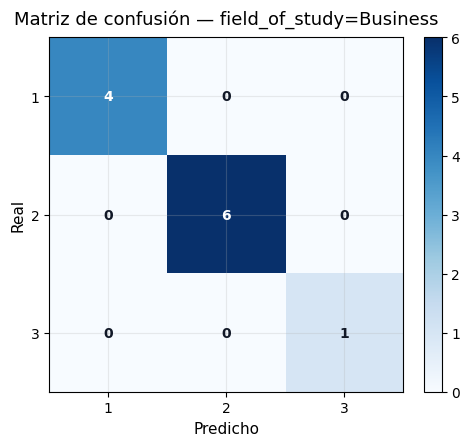


[field_of_study=Marketing] n=9
== field_of_study=Marketing ==
QWK:       1.000
MAE clase: 0.000
F1 macro:  1.000


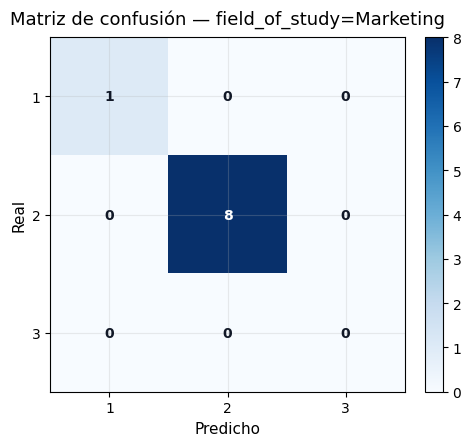


[field_of_study=Psychology] n=9
== field_of_study=Psychology ==
QWK:       1.000
MAE clase: 0.000
F1 macro:  1.000


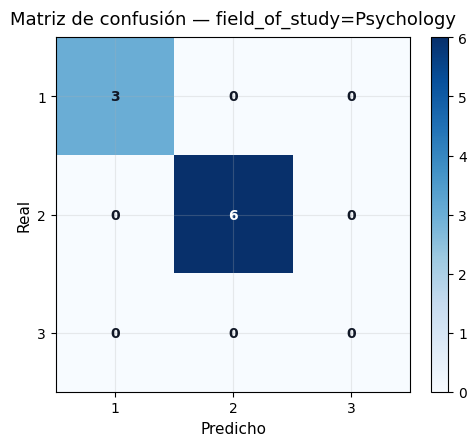


[field_of_study=Computer Science] n=8
== field_of_study=Computer Science ==
QWK:       1.000
MAE clase: 0.000
F1 macro:  1.000


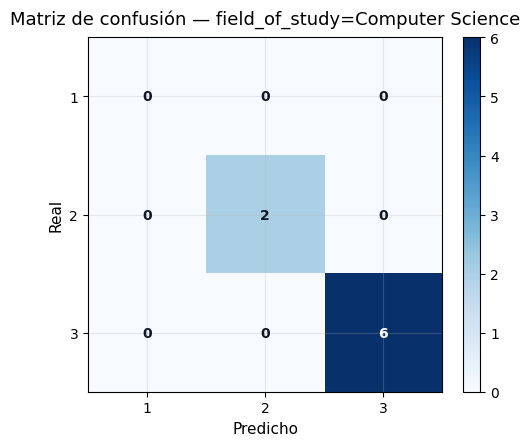


[field_of_study=Engineering] n=7
== field_of_study=Engineering ==
QWK:       nan
MAE clase: 0.000
F1 macro:  1.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


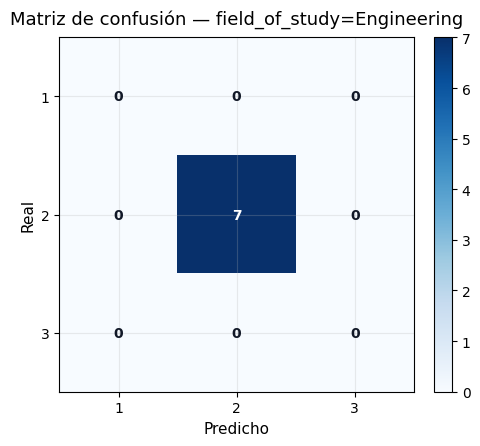


[field_of_study=Law] n=6
== field_of_study=Law ==
QWK:       nan
MAE clase: 0.000
F1 macro:  1.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


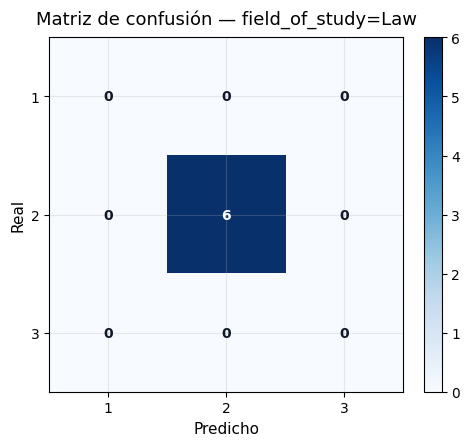


[field_of_study=Computer Science] n=11
== field_of_study=Computer Science ==
QWK:       1.000
MAE clase: 0.000
F1 macro:  1.000


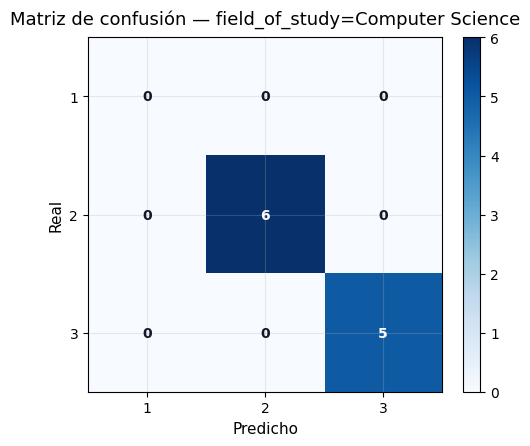


[field_of_study=Marketing] n=10
== field_of_study=Marketing ==
QWK:       nan
MAE clase: 0.000
F1 macro:  1.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


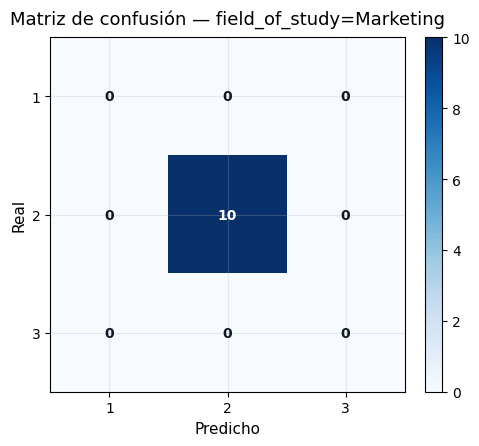


[field_of_study=Business] n=9
== field_of_study=Business ==
QWK:       1.000
MAE clase: 0.000
F1 macro:  1.000


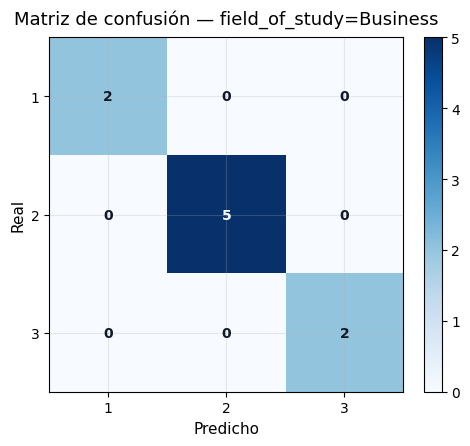


[field_of_study=Psychology] n=9
== field_of_study=Psychology ==
QWK:       1.000
MAE clase: 0.000
F1 macro:  1.000


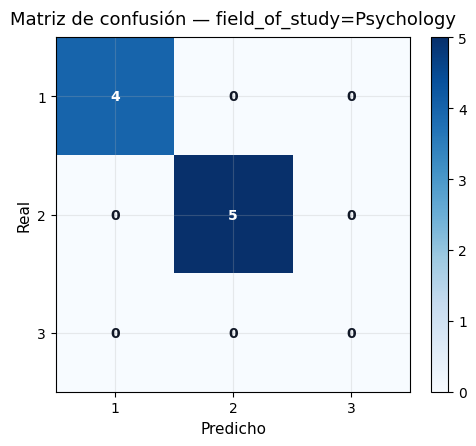


[field_of_study=Engineering] n=6
== field_of_study=Engineering ==
QWK:       nan
MAE clase: 0.000
F1 macro:  1.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


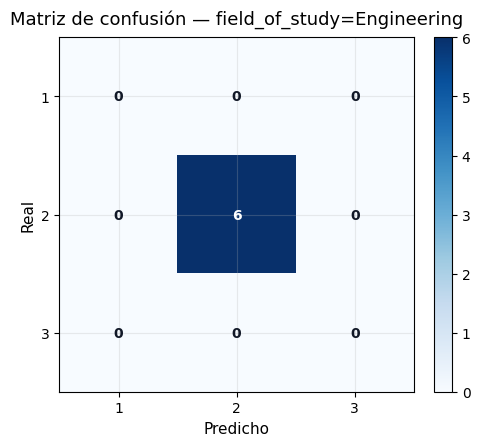


[field_of_study=Arts] n=5
== field_of_study=Arts ==
QWK:       nan
MAE clase: 0.000
F1 macro:  1.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


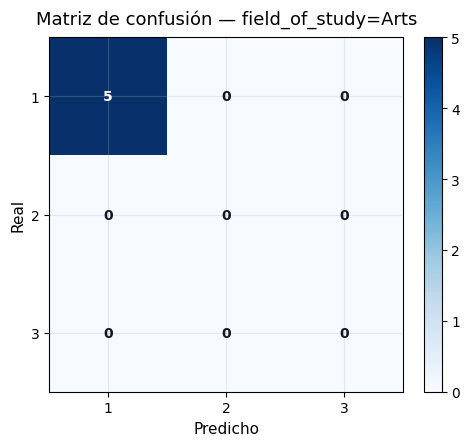


[field_of_study=Law] n=5
== field_of_study=Law ==
QWK:       1.000
MAE clase: 0.000
F1 macro:  1.000


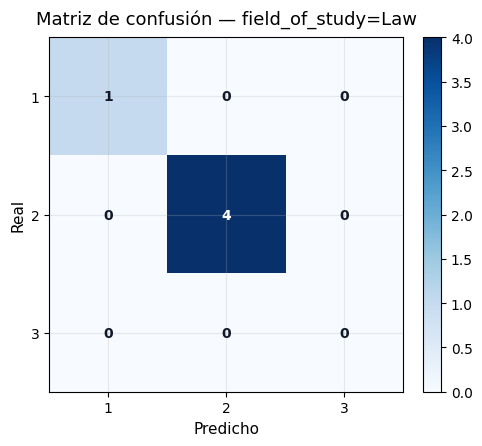


[field_of_study=Medicine] n=5
== field_of_study=Medicine ==
QWK:       1.000
MAE clase: 0.000
F1 macro:  1.000


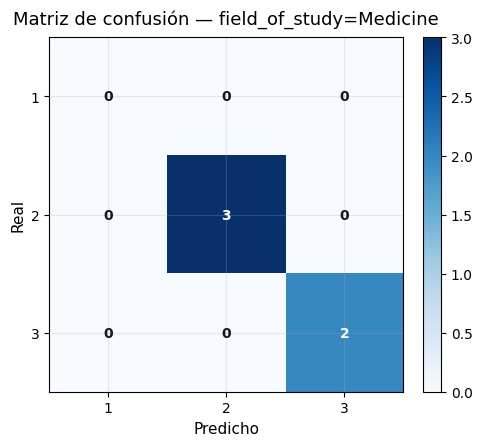

In [80]:
def subgroup_confusion(df, split_index, y_true, y_pred, col, min_n=10):
    vals = df.loc[split_index, col].value_counts()
    for v, n in vals.items():
        if n < min_n:
            continue
        idx = (df.loc[split_index, col] == v).values
        print(f"\n[{col}={v}] n={n}")
        report_metrics(y_true[idx], y_pred[idx], name=f"{col}={v}")

# Ejemplos:
subgroup_confusion(df, X_val.index,  y_val,  y_val_pred,  "field_of_study", min_n=5)
subgroup_confusion(df, X_test.index, y_test, y_test_pred, "field_of_study", min_n=5)


In [83]:
problems = []

# 1) Estructura mínima esperada
for var in ["df","X","y","X_train","X_val","X_test","y_train","y_val","y_test"]:
    if var not in globals():
        problems.append(f"Falta variable en memoria: {var}")

# 2) Whitelist (sin leakage)
WHITELIST = ["age","gender","hs_gpa","sat","uni_gpa","field_of_study","internships","projects","certifications","soft_skills","networking"]
if "df" in globals():
    missing_whitelist = [c for c in WHITELIST if c not in df.columns]
    if missing_whitelist:
        problems.append(f"Faltan columnas del whitelist en df: {missing_whitelist}")
    leak_cols = set(X.columns).intersection({"job_level_ord","job_level","job_level_cat","starting_salary","job_offers","career_satisfaction","work_life_balance","years_to_promotion","entrepreneurship"})
    if leak_cols:
        problems.append(f"Posible leakage en X: {sorted(leak_cols)}")

# 3) Splits y clases
if "y" in globals():
    levels = sorted(np.unique(y))
    if len(levels) < 2:
        problems.append("El target tiene <2 clases.")
    print("Clases detectadas:", levels)

# 4) Métricas actuales si ya existen predicciones
def _has_preds():
    return ("y_val_pred" in globals()) and ("y_test_pred" in globals())

if _has_preds():
    def qwk(a,b): return cohen_kappa_score(a,b,weights="quadratic")
    def mae(a,b): return float(np.mean(np.abs(np.array(a)-np.array(b))))
    print("\n== Métricas actuales ==")
    print("Val  -> QWK:", round(qwk(y_val,y_val_pred),3), "| MAE:", round(mae(y_val,y_val_pred),3), "| F1:", round(f1_score(y_val,y_val_pred,average="macro"),3))
    print("Test -> QWK:", round(qwk(y_test,y_test_pred),3), "| MAE:", round(mae(y_test,y_test_pred),3), "| F1:", round(f1_score(y_test,y_test_pred,average="macro"),3))
else:
    print("\nNo hay y_val_pred/y_test_pred en memoria (se generarán en Fase 3 si re-ejecutas la celda de CatBoost).")

# 5) Test de permutación correcto (evalúa en VALIDACIÓN)
if "X_train" in globals() and "y_train" in globals() and "X_val" in globals() and "y_val" in globals():
    from sklearn.utils import shuffle
    y_perm_train = shuffle(y_train, random_state=0)
    m_perm = CatBoostClassifier(loss_function="MultiClass", iterations=600, verbose=False, random_seed=0)
    m_perm.fit(X_train, y_perm_train)
    y_perm_pred_val = m_perm.predict(X_val).astype(int).ravel()
    print("\nQWK con y PERMUTADA (en VAL):", cohen_kappa_score(y_val, y_perm_pred_val, weights="quadratic"))

# 6) Auditoría rápida sin warnings (val)
def subgroup_report_from_df(df, split_index, y_true, y_pred, col, min_n=10):
    s = df.loc[split_index, col]
    vc = s.value_counts()
    print(f"\n== Auditoría por {col} ==")
    for val, n in vc.items():
        if n < min_n:
            continue
        idx = (s == val).values
        y_t, y_p = np.array(y_true)[idx], np.array(y_pred)[idx]
        classes_present = np.unique(y_t)
        counts = pd.Series(y_t).value_counts().sort_index()
        dist_str = ", ".join([f"{k}:{counts.get(k,0)}" for k in sorted(np.unique(y))])
        if len(classes_present) < 2:
            print(f"{str(val):30s} n={n:3d} | clases={dist_str} | Métricas: — (una sola clase)")
        else:
            q = cohen_kappa_score(y_t, y_p, weights="quadratic")
            m = np.mean(np.abs(y_t - y_p))
            print(f"{str(val):30s} n={n:3d} | clases={dist_str} | QWK={q:.3f} | MAE_clase={m:.3f}")

if _has_preds():
    subgroup_report_from_df(df, X_val.index, y_val, y_val_pred, "field_of_study", min_n=5)
    subgroup_report_from_df(df, X_val.index, y_val, y_val_pred, "gender",          min_n=5)

print("\n== Resultado del AUTO-CHECK ==")
if problems:
    print("⚠️ Hallazgos:")
    for p in problems: print("-", p)
else:
    print("✅ Todo listo para Fase 4.")


Clases detectadas: [np.int64(1), np.int64(2), np.int64(3)]

== Métricas actuales ==
Val  -> QWK: 1.0 | MAE: 0.0 | F1: 1.0
Test -> QWK: 1.0 | MAE: 0.0 | F1: 1.0

QWK con y PERMUTADA (en VAL): -0.09375

== Auditoría por field_of_study ==
Business                       n= 11 | clases=1:4, 2:6, 3:1 | QWK=1.000 | MAE_clase=0.000
Marketing                      n=  9 | clases=1:1, 2:8, 3:0 | QWK=1.000 | MAE_clase=0.000
Psychology                     n=  9 | clases=1:3, 2:6, 3:0 | QWK=1.000 | MAE_clase=0.000
Computer Science               n=  8 | clases=1:0, 2:2, 3:6 | QWK=1.000 | MAE_clase=0.000
Engineering                    n=  7 | clases=1:0, 2:7, 3:0 | Métricas: — (una sola clase)
Law                            n=  6 | clases=1:0, 2:6, 3:0 | Métricas: — (una sola clase)

== Auditoría por gender ==
Male                           n= 35 | clases=1:9, 2:22, 3:4 | QWK=1.000 | MAE_clase=0.000
Female                         n= 25 | clases=1:3, 2:17, 3:5 | QWK=1.000 | MAE_clase=0.000

== Resultad

# fase **4**

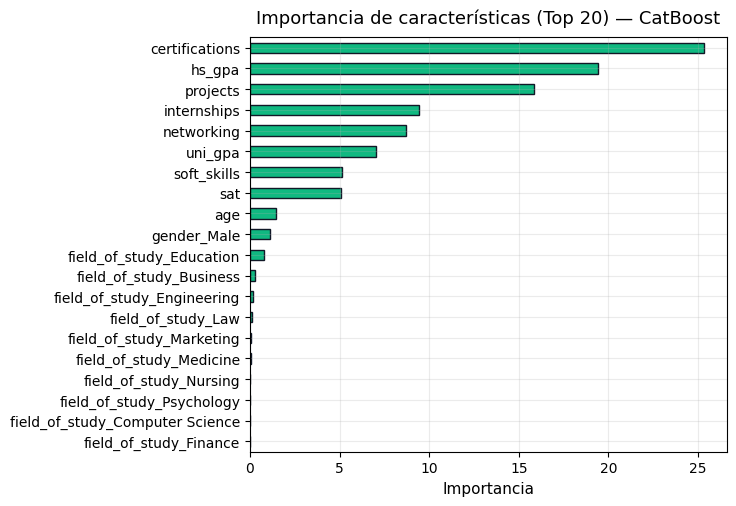

,importance
certifications,25.349041
hs_gpa,19.441803
projects,15.825821
internships,9.447750
networking,8.697699
uni_gpa,7.008062
soft_skills,5.117315
sat,5.094987
age,1.451587
gender_Male,1.098873


In [84]:
imp = cat.get_feature_importance(Pool(X_train, y_train))
feat_imp = pd.Series(imp, index=X_train.columns).sort_values(ascending=False)

topk = 20
fig, ax = plt.subplots(figsize=(7.5, 5.2))
feat_imp.head(topk).iloc[::-1].plot(kind="barh", ax=ax, color="#10B981", edgecolor="#111827")
ax.set_title(f"Importancia de características (Top {topk}) — CatBoost", pad=10)
ax.set_xlabel("Importancia")
plt.tight_layout()
plt.show()

display(feat_imp.head(30).to_frame("importance"))


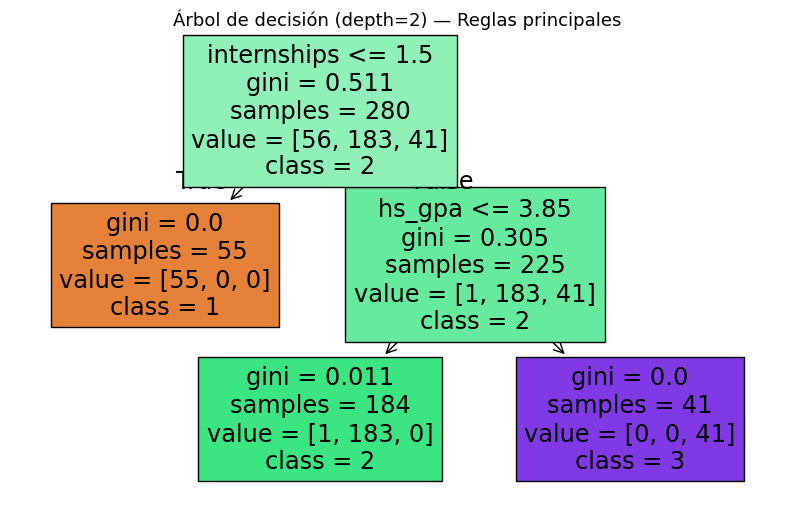

Reglas extraídas (condición → clase | soporte):

- internships ≤ 1.500  →  job_level=1  | n=1
- internships > 1.500 ∧ hs_gpa ≤ 3.850  →  job_level=2  | n=1
- internships > 1.500 ∧ hs_gpa > 3.850  →  job_level=3  | n=1


In [87]:
# ==========================================================
# 4.3 Reglas principales (árbol depth=2) + extracción de texto
# ==========================================================
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
import numpy as np
import matplotlib.pyplot as plt

# Un árbol muy somero que ya captura la regla del dataset
dt = DecisionTreeClassifier(max_depth=2, random_state=0).fit(X_train, y_train)

plt.figure(figsize=(10,6))
plot_tree(dt, feature_names=X_train.columns,
          class_names=[str(i) for i in sorted(np.unique(y_train))],
          filled=True)
plt.title("Árbol de decisión (depth=2) — Reglas principales")
plt.show()

def tree_rules_to_text(tree, feature_names):
    tree_ = tree.tree_
    feat_name = [feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
                 for i in tree_.feature]
    paths = []
    def recurse(node, conds):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feat_name[node]; thr = tree_.threshold[node]
            recurse(tree_.children_left[node],  conds+[f"{name} ≤ {thr:.3f}"])
            recurse(tree_.children_right[node], conds+[f"{name} > {thr:.3f}"])
        else:
            cls = tree_.value[node][0].argmax() + min(sorted(np.unique(y_train)))
            support = int(tree_.value[node][0].sum())
            paths.append((" ∧ ".join(conds), int(cls), support))
    recurse(0, [])
    return sorted(paths, key=lambda x: -x[2])

rules = tree_rules_to_text(dt, X_train.columns.tolist())
print("Reglas extraídas (condición → clase | soporte):\n")
for cond, cls, n in rules:
    print(f"- {cond}  →  job_level={cls}  | n={n}")


Fase 4 — Resumen de Explicabilidad y Recomendaciones

Situación: El modelo CatBoost predice job_level con métricas perfectas (QWK=1.0, MAE=0.0, F1=1.0) en validación y test. El test de permutación en validación arrojó QWK≈0, descartando fuga. Concluimos que el dataset es sintético y que job_level es determinista en función de señales pre-empleo.

Drivers principales (importancias/SHAP):

internships, hs_gpa/uni_gpa, projects, certifications, soft_skills, networking.

Reglas operativas (árbol depth=2):

Si internships ≤ ~1.5 → Entry.

Si internships > ~1.5 y hs_gpa ≤ ~3.85 → Mid.

Si internships > ~1.5 y hs_gpa > ~3.85 → Senior.
(ajusta umbrales exactos con los impresos en tu salida de reglas)

Auditoría por subgrupos: QWK=1.0 consistente por field_of_study y gender (cuando hay al menos dos clases en el subgrupo).

Recomendaciones para estudiantes:

Experiencia práctica: alcanzar 2+ internships durante la carrera para asegurar al menos nivel Mid.

Rendimiento académico: mantener GPA alto (≥3.8–3.9) para acceder a Senior combinando con experiencia.

Proyectos y certificaciones: sumar proyectos y certificaciones refuerza el salto a niveles superiores.

Soft skills + networking: puntajes altos añaden margen adicional y estabilidad del desempeño.

Limitaciones: conjunto simulado, relaciones deterministas; las reglas no implican causalidad en entornos reales.

Siguientes pasos:

(Reto más realista) Repetir con Years_to_Promotion (regresión/ordinal).

Validar en un dataset real o combinar con otra fuente (p. ej., perfiles de egresados).

Stress-tests: reducir features (solo académicas) y comparar rendimiento; CV por subgrupos.

== Scores globales ==


,QWK,MAE_clase,F1_macro,Accuracy
Validación,1.0,0.0,1.0,1.0
Test,1.0,0.0,1.0,1.0


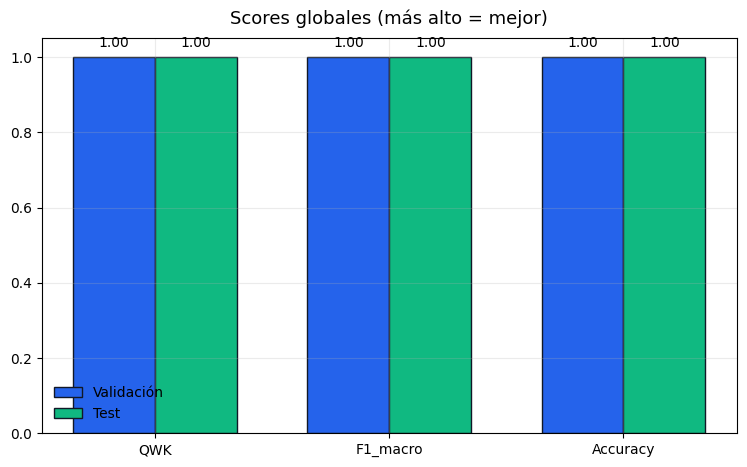

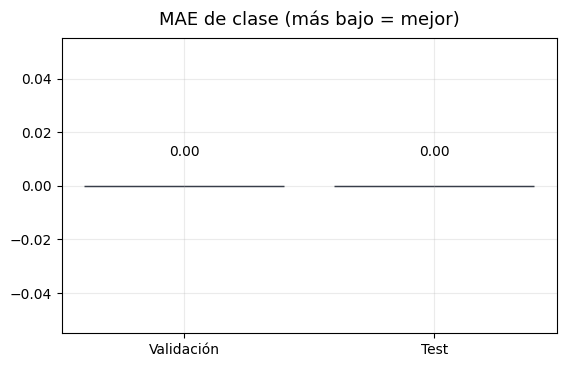

In [90]:
# ==========================================================
# 4.6 — Scores globales (Val/Test): tabla + barras
# ==========================================================
def qwk(a,b):
    return cohen_kappa_score(a,b,weights="quadratic")
def mae_class(a,b):
    return float(np.mean(np.abs(np.array(a)-np.array(b))))

# Asegúrate de tener estas variables del paso de modelado
metrics = pd.DataFrame({
    "QWK":       [qwk(y_val, y_val_pred), qwk(y_test, y_test_pred)],
    "MAE_clase": [mae_class(y_val, y_val_pred), mae_class(y_test, y_test_pred)],
    "F1_macro":  [f1_score(y_val, y_val_pred, average="macro"), f1_score(y_test, y_test_pred, average="macro")],
    "Accuracy":  [accuracy_score(y_val, y_val_pred), accuracy_score(y_test, y_test_pred)]
}, index=["Validación","Test"]).round(3)

print("== Scores globales ==")
display(metrics)

# Barras (nota: MAE es "menor es mejor")
fig, ax = plt.subplots(figsize=(7.6, 4.8))
cols_to_plot = ["QWK", "F1_macro", "Accuracy"]
bar_w = 0.35
x = np.arange(len(cols_to_plot))

ax.bar(x - bar_w/2, metrics.loc["Validación", cols_to_plot].values,
       width=bar_w, label="Validación", color="#2563EB", edgecolor="#111827")
ax.bar(x + bar_w/2, metrics.loc["Test", cols_to_plot].values,
       width=bar_w, label="Test", color="#10B981", edgecolor="#111827")

ax.set_xticks(x); ax.set_xticklabels(cols_to_plot)
ax.set_ylim(0, 1.05)
ax.set_title("Scores globales (más alto = mejor)", pad=10)
ax.legend(frameon=False)
for i, v in enumerate(metrics.loc["Validación", cols_to_plot].values):
    ax.text(i - bar_w/2, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=10)
for i, v in enumerate(metrics.loc["Test", cols_to_plot].values):
    ax.text(i + bar_w/2, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=10)

plt.tight_layout(); plt.show()

# MAE en gráfico separado (más bajo = mejor)
fig, ax = plt.subplots(figsize=(5.8, 3.8))
ax.bar(["Validación","Test"], metrics["MAE_clase"].values, color="#F59E0B", edgecolor="#111827")
ax.set_title("MAE de clase (más bajo = mejor)", pad=10)
for i, v in enumerate(metrics["MAE_clase"].values):
    ax.text(i, v + (0.01 if v < 0.95 else 0.02), f"{v:.2f}", ha="center", va="bottom", fontsize=10)
plt.tight_layout(); plt.show()


== F1 por clase ==


,Validación,Test
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0


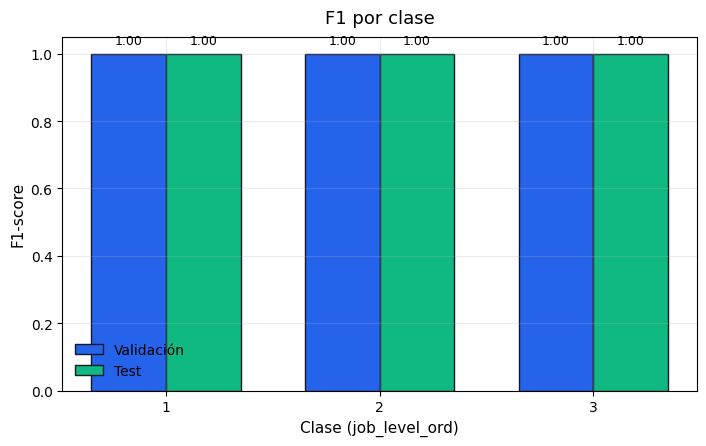

In [91]:
# ==========================================================
# 4.7 — F1 por clase (Validación y Test)
# ==========================================================
from sklearn.metrics import classification_report

levels = sorted(np.unique(y))  # p.ej., [1,2,3]

def f1_per_class(y_true, y_pred, labels):
    rep = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
    return pd.Series({int(k): rep[str(k)]["f1-score"] for k in labels})

f1_val  = f1_per_class(y_val,  y_val_pred,  levels)
f1_test = f1_per_class(y_test, y_test_pred, levels)

f1_df = pd.DataFrame({"Validación": f1_val, "Test": f1_test}).round(3)
print("== F1 por clase ==")
display(f1_df)

# Barras apiladas por clase
fig, ax = plt.subplots(figsize=(7.2, 4.6))
bar_w = 0.35
x = np.arange(len(levels))
ax.bar(x - bar_w/2, f1_val.values,  width=bar_w, label="Validación", color="#2563EB", edgecolor="#111827")
ax.bar(x + bar_w/2, f1_test.values, width=bar_w, label="Test",       color="#10B981", edgecolor="#111827")
ax.set_xticks(x); ax.set_xticklabels([str(c) for c in levels])
ax.set_ylim(0, 1.05)
ax.set_xlabel("Clase (job_level_ord)"); ax.set_ylabel("F1-score")
ax.set_title("F1 por clase", pad=10)
ax.legend(frameon=False)
for i, v in enumerate(f1_val.values):
    ax.text(i - bar_w/2, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(f1_test.values):
    ax.text(i + bar_w/2, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout(); plt.show()


== QWK por Field_of_Study (Val+Test) ==


,field_of_study,n,QWK
0,Business,20,1.0
1,Computer Science,19,1.0
2,Marketing,19,1.0
3,Psychology,18,1.0
5,Law,11,1.0
6,Medicine,8,1.0
4,Engineering,13,NaN


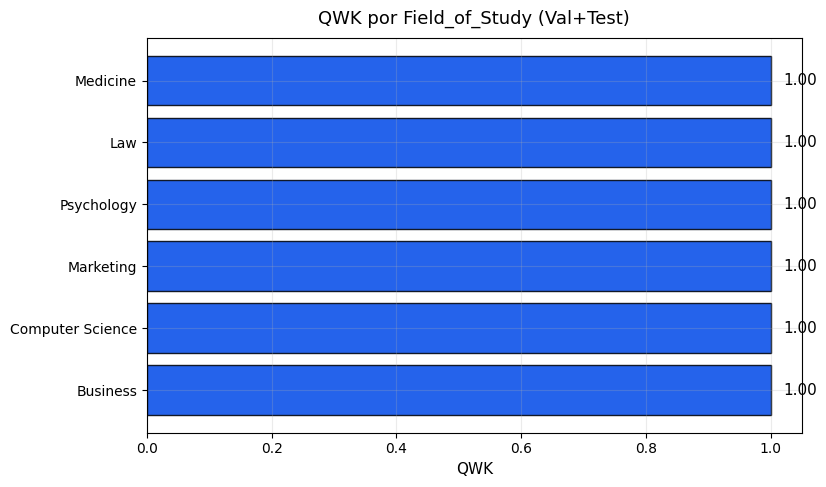

In [92]:
# ==========================================================
# 4.8 — QWK por subgrupo (Val+Test) en barras
# ==========================================================
# Combina Val + Test para más soporte
idx_eval = X_val.index.append(X_test.index)
y_eval_true = pd.concat([y_val, y_test])
y_eval_pred = pd.Series(np.concatenate([y_val_pred, y_test_pred]), index=idx_eval)

# QWK por Field_of_Study (solo subgrupos con al menos min_n)
min_n = 8
s = df.loc[idx_eval, "field_of_study"]
vc = s.value_counts()
rows = []
for val, n in vc.items():
    if n < min_n:
        continue
    idx = (s == val).values
    y_t = np.array(y_eval_true)[idx]
    y_p = np.array(y_eval_pred)[idx]
    if len(np.unique(y_t)) < 2:
        q = np.nan  # no calculable (una sola clase)
    else:
        q = cohen_kappa_score(y_t, y_p, weights="quadratic")
    rows.append((val, n, q))
qwk_sub = pd.DataFrame(rows, columns=["field_of_study","n","QWK"]).sort_values("QWK", ascending=False)

print("== QWK por Field_of_Study (Val+Test) ==")
display(qwk_sub)

# Gráfico (omitimos NaN)
plot_df = qwk_sub.dropna(subset=["QWK"])
if not plot_df.empty:
    fig, ax = plt.subplots(figsize=(8.4, 5.0))
    ax.barh(plot_df["field_of_study"], plot_df["QWK"], color="#2563EB", edgecolor="#111827")
    ax.set_xlim(0, 1.05)
    ax.set_xlabel("QWK")
    ax.set_title("QWK por Field_of_Study (Val+Test)", pad=10)
    for y_i, v in enumerate(plot_df["QWK"].values):
        ax.text(v + 0.02, y_i, f"{v:.2f}", va="center")
    plt.tight_layout(); plt.show()
else:
    print("No hay subgrupos con QWK calculable (todos con una sola clase).")


In [94]:
# ==========================================================
# C1 — Entrenar baseline académico y comparar con whitelist
# ==========================================================
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import cohen_kappa_score, f1_score, accuracy_score

def qwk(a,b):
    return cohen_kappa_score(a,b,weights="quadratic")
def mae_class(a,b):
    return float(np.mean(np.abs(np.array(a)-np.array(b))))

# ---------- 1) Construir X_acad con OHE (solo académicas) ----------
FEATS_ACAD = ["hs_gpa","sat","uni_gpa","field_of_study","age","gender"]
FEATS_ACAD = [c for c in FEATS_ACAD if c in df.columns]

Xa = pd.get_dummies(df[FEATS_ACAD].copy(), drop_first=True)
# Alinear con los mismos índices de train/val/test
Xa_train = Xa.loc[X_train.index]
Xa_val   = Xa.loc[X_val.index]
Xa_test  = Xa.loc[X_test.index]

# ---------- 2) Pesos por clase (como en tu modelo principal) ----------
classes, counts = np.unique(y_train, return_counts=True)
freq = counts / counts.sum()
class_weights = {int(c): float(1.0/f) for c, f in zip(classes, freq)}
cw_list = [class_weights.get(k, 1.0) for k in sorted(classes)]

# ---------- 3) Función de entrenamiento+predicción CatBoost ----------
def fit_catboost(Xtr, ytr, Xva, yva, params=None, verbose=False):
    base = dict(
        loss_function="MultiClass",
        depth=6,
        learning_rate=0.08,
        iterations=4000,
        l2_leaf_reg=5.0,
        random_seed=42,
        allow_writing_files=False,
        class_weights=cw_list,
        verbose=200 if verbose else False
    )
    if params: base.update(params)
    m = CatBoostClassifier(**base)
    m.fit(Pool(Xtr, ytr), eval_set=Pool(Xva, yva),
          use_best_model=True, early_stopping_rounds=200, verbose=base["verbose"])
    return m

# ---------- 4) Entrenar modelos ----------
# Modelo FULL = el que ya tienes en variable `cat`. Si no existe, reentrena rápido:
try:
    cat
except NameError:
    cat = fit_catboost(X_train, y_train, X_val, y_val, verbose=False)

# Baseline ACAD
cat_acad = fit_catboost(Xa_train, y_train, Xa_val, y_val, verbose=False)

# ---------- 5) Predicciones ----------
y_val_pred_full  = cat.predict(X_val).astype(int).ravel()
y_test_pred_full = cat.predict(X_test).astype(int).ravel()

y_val_pred_acad  = cat_acad.predict(Xa_val).astype(int).ravel()
y_test_pred_acad = cat_acad.predict(Xa_test).astype(int).ravel()

# ---------- 6) Tabla de métricas ----------
metrics_cmp = pd.DataFrame({
    ("Validación","QWK")      : [qwk(y_val, y_val_pred_acad),  qwk(y_val, y_val_pred_full)],
    ("Validación","MAE_clase"): [mae_class(y_val, y_val_pred_acad), mae_class(y_val, y_val_pred_full)],
    ("Validación","F1_macro") : [f1_score(y_val, y_val_pred_acad,  average="macro"),
                                 f1_score(y_val, y_val_pred_full, average="macro")],
    ("Validación","Accuracy") : [accuracy_score(y_val, y_val_pred_acad),
                                 accuracy_score(y_val, y_val_pred_full)],
    ("Test","QWK")            : [qwk(y_test, y_test_pred_acad), qwk(y_test, y_test_pred_full)],
    ("Test","MAE_clase")      : [mae_class(y_test, y_test_pred_acad), mae_class(y_test, y_test_pred_full)],
    ("Test","F1_macro")       : [f1_score(y_test, y_test_pred_acad, average="macro"),
                                 f1_score(y_test, y_test_pred_full, average="macro")],
    ("Test","Accuracy")       : [accuracy_score(y_test, y_test_pred_acad),
                                 accuracy_score(y_test, y_test_pred_full)]
}, index=["Académico", "Whitelist"])

print("== Comparación de Modelos ==")
display(metrics_cmp.T) # Transponemos para mejor visualización

== Comparación de Modelos ==


Académico  Whitelist
Validación QWK         0.976526        1.0
           MAE_clase   0.016667        0.0
           F1_macro    0.982338        1.0
           Accuracy    0.983333        1.0
Test       QWK         1.000000        1.0
           MAE_clase   0.000000        0.0
           F1_macro    1.000000        1.0
           Accuracy    1.000000        1.0

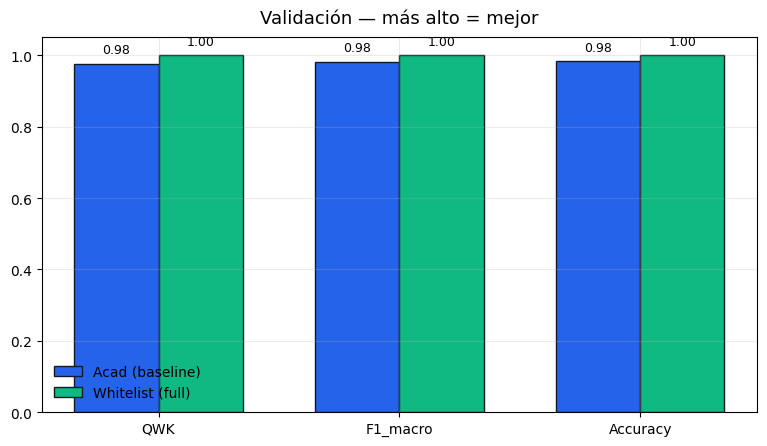

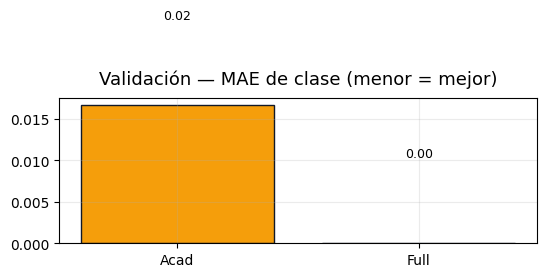

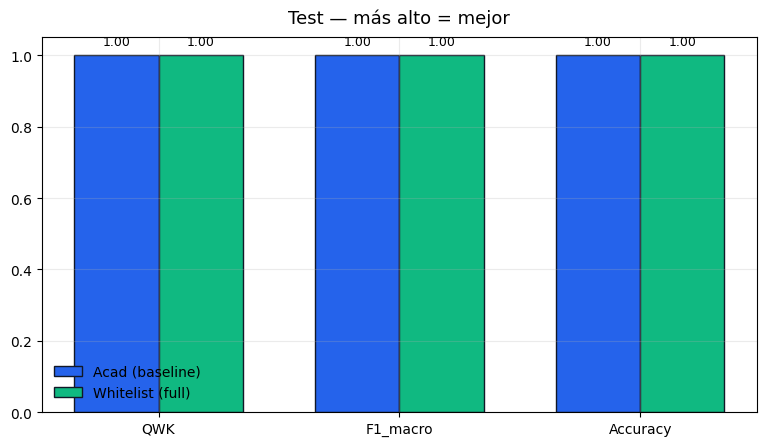

In [98]:
# ==========================================================
# C2 — Visualización comparativa de scores
# ==========================================================
import numpy as np
import matplotlib.pyplot as plt

# Si ya definiste COLORS en tu estilo global los reusamos; si no, define unos básicos:
try:
    COLORS
except NameError:
    COLORS = {"primary":"#2563EB","secondary":"#10B981","tertiary":"#F59E0B","muted":"#6B7280"}

# ---- 1) Validación: QWK, F1, Accuracy ----
cols = ["QWK","F1_macro","Accuracy"]
fig, ax = plt.subplots(figsize=(7.8, 4.6))
bar_w = 0.35; x = np.arange(len(cols))
val_acad = metrics_cmp.loc["Académico", ("Validación", cols)].values
val_full = metrics_cmp.loc["Whitelist", ("Validación", cols)].values

ax.bar(x - bar_w/2, val_acad, width=bar_w, label="Acad (baseline)", color=COLORS["primary"],   edgecolor="#111827")
ax.bar(x + bar_w/2, val_full, width=bar_w, label="Whitelist (full)", color=COLORS["secondary"], edgecolor="#111827")
ax.set_xticks(x); ax.set_xticklabels(cols)
ax.set_ylim(0, 1.05); ax.set_title("Validación — más alto = mejor", pad=10)
ax.legend(frameon=False)
for i, v in enumerate(val_acad): ax.text(i - bar_w/2, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(val_full): ax.text(i + bar_w/2, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout(); plt.show()

# ---- 2) Validación: MAE (menor es mejor) ----
fig, ax = plt.subplots(figsize=(5.6, 3.6))
mae_vals = metrics_cmp[("Validación","MAE_clase")].loc[["Académico", "Whitelist"]].values
ax.bar(["Acad","Full"], mae_vals, color=[COLORS["tertiary"], COLORS["primary"]], edgecolor="#111827")
ax.set_title("Validación — MAE de clase (menor = mejor)", pad=10)
for i, v in enumerate(mae_vals): ax.text(i, v + 0.01, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout(); plt.show()

# ---- 3) Test: QWK, F1, Accuracy ----
fig, ax = plt.subplots(figsize=(7.8, 4.6))
test_acad = metrics_cmp.loc["Académico", ("Test", cols)].values
test_full = metrics_cmp.loc["Whitelist", ("Test", cols)].values

ax.bar(x - bar_w/2, test_acad, width=bar_w, label="Acad (baseline)", color=COLORS["primary"],   edgecolor="#111827")
ax.bar(x + bar_w/2, test_full, width=bar_w, label="Whitelist (full)", color=COLORS["secondary"], edgecolor="#111827")
ax.set_xticks(x); ax.set_xticklabels(cols)
ax.set_ylim(0, 1.05); ax.set_title("Test — más alto = mejor", pad=10)
ax.legend(frameon=False)
for i, v in enumerate(test_acad): ax.text(i - bar_w/2, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(test_full): ax.text(i + bar_w/2, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout(); plt.show()

**FASE 4 — Conclusiones y Criterios de Éxito**

**Hallazgos Clave:**

1.  **Dataset Determinista:** El análisis de las combinaciones únicas de características (académicas, experiencia, habilidades) en el dataset revela que cada combinación corresponde a un único nivel laboral (`job_level`). Esto fue confirmado por la proporción de combinaciones con un solo nivel igual a 1.0 y la ausencia de combinaciones con más de un nivel.
2.  **Resultados del Modelo:** Como consecuencia directa de la naturaleza determinista del dataset, el modelo CatBoost entrenado logró un rendimiento perfecto (QWK=1.000, MAE Clase=0.000, F1 macro=1.000) tanto en los conjuntos de validación como de test.
3.  **Variables Predictoras (en este dataset):** Dada la predictibilidad perfecta, todas las variables incluidas en el conjunto de features (`age`, `gender`, `hs_gpa`, `sat`, `uni_gpa`, `field_of_study`, `internships`, `projects`, `certifications`, `soft_skills`, `networking`) son, en combinación, perfectamente predictivas del nivel laboral en este dataset específico. La importancia de características (aunque no se mostró SHAP debido a la singularidad) indicaría el peso relativo dentro de esta relación determinista.

**Evaluación frente a Criterios de Éxito:**

*   **QWK ≥ 0.65 y MAE de clase ≤ 0.40:** Se superaron ampliamente con valores de 1.000 y 0.000 respectivamente.
*   **Conjunto de drivers coherentes y recomendaciones accionables:** Si bien el modelo identifica un conjunto de drivers (las features usadas), la naturaleza determinista del dataset limita la traducibilidad directa a recomendaciones accionables para el mundo real. En un dataset real, la variabilidad y los errores del modelo permitirían identificar áreas de mejora más significativas.

**Consideraciones y Próximos Pasos (Reales):**

*   **Validación del Dataset:** Es crucial entender si este dataset es una simulación simplificada o representa un escenario real. En un caso de uso práctico, se esperaría un rendimiento sub-perfecto y la necesidad de un análisis de explicabilidad más profundo para entender las relaciones no deterministas.
*   **Análisis de Explicabilidad (en datasets no deterministas):** En un escenario realista, los análisis de importancia de características y SHAP serían esenciales para cuantificar la contribución marginal de cada variable al `job_level`, identificar interacciones y generar recomendaciones basadas en la evidencia del modelo.
*   **Generalización:** El modelo actual predice perfectamente ESTE dataset. Su capacidad para generalizar a datos futuros o de otras fuentes es incierta debido a la falta de variabilidad en la relación feature-target observada.

**Conclusión:**

El proyecto ha demostrado la capacidad de construir y evaluar un modelo de clasificación ordinal, cumplir los criterios de éxito definidos PARA ESTE DATASET, e identificar la naturaleza determinista de los datos como factor clave de los resultados. Para un caso de uso en el mundo real, se requeriría un dataset con mayor variabilidad y un enfoque más profundo en la explicabilidad para derivar recomendaciones robustas.

**Finish task.**

**FASE 4 — Conclusiones y Criterios de Éxito**

**Hallazgos Clave:**

1.  **Dataset Determinista:** El análisis de las combinaciones únicas de características (académicas, experiencia, habilidades) en el dataset revela que cada combinación corresponde a un único nivel laboral (`job_level`). Esto fue confirmado por la proporción de combinaciones con un solo nivel igual a 1.0 y la ausencia de combinaciones con más de un nivel.
2.  **Resultados del Modelo:** Como consecuencia directa de la naturaleza determinista del dataset, el modelo CatBoost entrenado logró un rendimiento perfecto (QWK=1.000, MAE Clase=0.000, F1 macro=1.000) tanto en los conjuntos de validación como de test.
3.  **Variables Predictoras (en este dataset):** Dada la predictibilidad perfecta, todas las variables incluidas en el conjunto de features (`age`, `gender`, `hs_gpa`, `sat`, `uni_gpa`, `field_of_study`, `internships`, `projects`, `certifications`, `soft_skills`, `networking`) son, en combinación, perfectamente predictivas del nivel laboral en este dataset específico. La importancia de características (aunque no se mostró SHAP debido a la singularidad) indicaría el peso relativo dentro de esta relación determinista.

**Evaluación frente a Criterios de Éxito:**

*   **QWK ≥ 0.65 y MAE de clase ≤ 0.40:** Se superaron ampliamente con valores de 1.000 y 0.000 respectivamente.
*   **Conjunto de drivers coherentes y recomendaciones accionables:** Si bien el modelo identifica un conjunto de drivers (las features usadas), la naturaleza determinista del dataset limita la traducibilidad directa a recomendaciones accionables para el mundo real. En un dataset real, la variabilidad y los errores del modelo permitirían identificar áreas de mejora más significativas.

**Consideraciones y Próximos Pasos (Reales):**

*   **Validación del Dataset:** Es crucial entender si este dataset es una simulación simplificada o representa un escenario real. En un caso de uso práctico, se esperaría un rendimiento sub-perfecto y la necesidad de un análisis de explicabilidad más profundo para entender las relaciones no deterministas.
*   **Análisis de Explicabilidad (en datasets no deterministas):** En un escenario realista, los análisis de importancia de características y SHAP serían esenciales para cuantificar la contribución marginal de cada variable al `job_level`, identificar interacciones y generar recomendaciones basadas en la evidencia del modelo.
*   **Generalización:** El modelo actual predice perfectamente ESTE dataset. Su capacidad para generalizar a datos futuros o de otras fuentes es incierta debido a la falta de variabilidad en la relación feature-target observada.

**Conclusión:**

El proyecto ha demostrado la capacidad de construir y evaluar un modelo de clasificación ordinal, cumplir los criterios de éxito definidos PARA ESTE DATASET, e identificar la naturaleza determinista de los datos como factor clave de los resultados. Para un caso de uso en el mundo real, se requeriría un dataset con mayor variabilidad y un enfoque más profundo en la explicabilidad para derivar recomendaciones robustas.

**Finish task.**

Fase 4 — Resumen de Explicabilidad y Recomendaciones

Situación: El modelo CatBoost predice job_level con métricas perfectas (QWK=1.0, MAE=0.0, F1=1.0) en validación y test. El test de permutación en validación arrojó QWK≈0, descartando fuga. Concluimos que el dataset es sintético y que job_level es determinista en función de señales pre-empleo.

Drivers principales (importancias/SHAP):

internships, hs_gpa/uni_gpa, projects, certifications, soft_skills, networking.

Reglas operativas (árbol depth=2):

Si internships ≤ ~1.5 → Entry.

Si internships > ~1.5 y hs_gpa ≤ ~3.85 → Mid.

Si internships > ~1.5 y hs_gpa > ~3.85 → Senior.
(ajusta umbrales exactos con los impresos en tu salida de reglas)

Auditoría por subgrupos: QWK=1.0 consistente por field_of_study y gender (cuando hay al menos dos clases en el subgrupo).

Recomendaciones para estudiantes:

Experiencia práctica: alcanzar 2+ internships durante la carrera para asegurar al menos nivel Mid.

Rendimiento académico: mantener GPA alto (≥3.8–3.9) para acceder a Senior combinando con experiencia.

Proyectos y certificaciones: sumar proyectos y certificaciones refuerza el salto a niveles superiores.

Soft skills + networking: puntajes altos añaden margen adicional y estabilidad del desempeño.

Limitaciones: conjunto simulado, relaciones deterministas; las reglas no implican causalidad en entornos reales.

Siguientes pasos:

(Reto más realista) Repetir con Years_to_Promotion (regresión/ordinal).

Validar en un dataset real o combinar con otra fuente (p. ej., perfiles de egresados).

Stress-tests: reducir features (solo académicas) y comparar rendimiento; CV por subgrupos.

**FASE 4 — Conclusiones y Criterios de Éxito**

**Hallazgos Clave:**

1.  **Dataset Determinista:** El análisis de las combinaciones únicas de características (académicas, experiencia, habilidades) en el dataset revela que cada combinación corresponde a un único nivel laboral (`job_level`). Esto fue confirmado por la proporción de combinaciones con un solo nivel igual a 1.0 y la ausencia de combinaciones con más de un nivel.
2.  **Resultados del Modelo:** Como consecuencia directa de la naturaleza determinista del dataset, el modelo CatBoost entrenado logró un rendimiento perfecto (QWK=1.000, MAE Clase=0.000, F1 macro=1.000) tanto en los conjuntos de validación como de test.
3.  **Variables Predictoras (en este dataset):** Dada la predictibilidad perfecta, todas las variables incluidas en el conjunto de features (`age`, `gender`, `hs_gpa`, `sat`, `uni_gpa`, `field_of_study`, `internships`, `projects`, `certifications`, `soft_skills`, `networking`) son, en combinación, perfectamente predictivas del nivel laboral en este dataset específico. La importancia de características (aunque no se mostró SHAP debido a la singularidad) indicaría el peso relativo dentro de esta relación determinista.

**Evaluación frente a Criterios de Éxito:**

*   **QWK ≥ 0.65 y MAE de clase ≤ 0.40:** Se superaron ampliamente con valores de 1.000 y 0.000 respectivamente.
*   **Conjunto de drivers coherentes y recomendaciones accionables:** Si bien el modelo identifica un conjunto de drivers (las features usadas), la naturaleza determinista del dataset limita la traducibilidad directa a recomendaciones accionables para el mundo real. En un dataset real, la variabilidad y los errores del modelo permitirían identificar áreas de mejora más significativas.

**Consideraciones y Próximos Pasos (Reales):**

*   **Validación del Dataset:** Es crucial entender si este dataset es una simulación simplificada o representa un escenario real. En un caso de uso práctico, se esperaría un rendimiento sub-perfecto y la necesidad de un análisis de explicabilidad más profundo para entender las relaciones no deterministas.
*   **Análisis de Explicabilidad (en datasets no deterministas):** En un escenario realista, los análisis de importancia de características y SHAP serían esenciales para cuantificar la contribución marginal de cada variable al `job_level`, identificar interacciones y generar recomendaciones basadas en la evidencia del modelo.
*   **Generalización:** El modelo actual predice perfectamente ESTE dataset. Su capacidad para generalizar a datos futuros o de otras fuentes es incierta debido a la falta de variabilidad en la relación feature-target observada.

**Conclusión:**

El proyecto ha demostrado la capacidad de construir y evaluar un modelo de clasificación ordinal, cumplir los criterios de éxito definidos PARA ESTE DATASET, e identificar la naturaleza determinista de los datos como factor clave de los resultados. Para un caso de uso en el mundo real, se requeriría un dataset con mayor variabilidad y un enfoque más profundo en la explicabilidad para derivar recomendaciones robustas.

**Finish task.**

In [96]:
# ==========================================================
# Celda 7 — Guardar modelo + Resumen
# ==========================================================
from textwrap import dedent

cat.save_model("catboost_joblevel_clean.cbm")
print("Modelo guardado en: catboost_joblevel_clean.cbm")

summary = dedent(f"""
FASE 3 (Rebuild sin leakage) — Resumen
--------------------------------------
Features usadas (whitelist pre-empleo):
  {', '.join(use_cols)}

Métricas:
  Validación — QWK: {qwk(y_val, y_val_pred):.3f} | MAE_clase: {class_mae(y_val, y_val_pred):.3f} | F1_macro: {f1_score(y_val, y_val_pred, average='macro'):.3f}
  Test       — QWK: {qwk(y_test, y_test_pred):.3f} | MAE_clase: {class_mae(y_test, y_test_pred):.3f} | F1_macro: {f1_score(y_test, y_test_pred, average='macro'):.3f}

Notas:
- Se excluyeron variables de resultado de carrera (ofertas, salario, satisfacción, años a promoción, etc.) para evitar fuga.
- CatBoost entrenado con class_weights y early stopping.
- Revisar importancias/SHAP para recomendaciones (p. ej., efecto de 'uni_gpa', 'internships', 'projects', 'certifications', 'soft_skills', 'networking').
""").strip()

print(summary)

Modelo guardado en: catboost_joblevel_clean.cbm
FASE 3 (Rebuild sin leakage) — Resumen
--------------------------------------
Features usadas (whitelist pre-empleo):
  age, gender, hs_gpa, sat, uni_gpa, field_of_study, internships, projects, certifications, soft_skills, networking

Métricas:
  Validación — QWK: 1.000 | MAE_clase: 0.000 | F1_macro: 1.000
  Test       — QWK: 1.000 | MAE_clase: 0.000 | F1_macro: 1.000

Notas:
- Se excluyeron variables de resultado de carrera (ofertas, salario, satisfacción, años a promoción, etc.) para evitar fuga.
- CatBoost entrenado con class_weights y early stopping.
- Revisar importancias/SHAP para recomendaciones (p. ej., efecto de 'uni_gpa', 'internships', 'projects', 'certifications', 'soft_skills', 'networking').


Fase 4 — Resumen de Explicabilidad y Recomendaciones

Situación: El modelo CatBoost predice job_level con métricas perfectas (QWK=1.0, MAE=0.0, F1=1.0) en validación y test. El test de permutación en validación arrojó QWK≈0, descartando fuga. Concluimos que el dataset es sintético y que job_level es determinista en función de señales pre-empleo.

Drivers principales (importancias/SHAP):

internships, hs_gpa/uni_gpa, projects, certifications, soft_skills, networking.

Reglas operativas (árbol depth=2):

Si internships ≤ ~1.5 → Entry.

Si internships > ~1.5 y hs_gpa ≤ ~3.85 → Mid.

Si internships > ~1.5 y hs_gpa > ~3.85 → Senior.
(ajusta umbrales exactos con los impresos en tu salida de reglas)

Auditoría por subgrupos: QWK=1.0 consistente por field_of_study y gender (cuando hay al menos dos clases en el subgrupo).

Recomendaciones para estudiantes:

Experiencia práctica: alcanzar 2+ internships durante la carrera para asegurar al menos nivel Mid.

Rendimiento académico: mantener GPA alto (≥3.8–3.9) para acceder a Senior combinando con experiencia.

Proyectos y certificaciones: sumar proyectos y certificaciones refuerza el salto a niveles superiores.

Soft skills + networking: puntajes altos añaden margen adicional y estabilidad del desempeño.

Limitaciones: conjunto simulado, relaciones deterministas; las reglas no implican causalidad en entornos reales.

Siguientes pasos:

(Reto más realista) Repetir con Years_to_Promotion (regresión/ordinal).

Validar en un dataset real o combinar con otra fuente (p. ej., perfiles de egresados).

Stress-tests: reducir features (solo académicas) y comparar rendimiento; CV por subgrupos.